---
# <center>**GRUPO 4 - DESAFIO CINEMATOGRÁFICO - MULHERES EM IA**</center>
---



In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importando bibliotecas que serão utilizadas para análise e modelagem

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregando e observando a base de dados

df = pd.read_csv('/content/drive/MyDrive/Desafio MIA - Grupo 4/Notebooks/BilheteriaObrasSemana.csv', encoding = 'ISO-8859-1', sep = ';')
df.head()

,TITULO_ORIGINAL,TITULO_BRASILEIRO,GENERO,PAIS_ORIGEM,CPB_ROE,COPIAS,SALAS,DT_INICIO_EXIBICAO,DT_FIM_EXIBICAO,PUBLICO,RENDA,RAZAO_SOCIAL_DISTRIBUIDORA,REGISTRO_DISTRIBUIDORA,CNPJ_DISTRIBUIDORA,ANO_CINEMATOGRAFICO
0,COLLEGE,COLEGIAIS EM APUROS,Ficção,Estados Unidos,E1600557700000,8,8,02/01/2009,08/01/2009,833,"5325,0",ANTONIO FERNANDES FILMES LTDA,532,02.668.665/0001-01,2009
1,O ABORTO DOS OUTROS,NaN,Documentário,Brasil,B0800890900000,1,1,02/01/2009,08/01/2009,40,"196,0",ANTONIO FERNANDES FILMES LTDA,532,02.668.665/0001-01,2009
2,ONDE ANDARÁ DULCE VEIGA?,NaN,Ficção,"Brasil, Chile",B0700801600000,1,1,02/01/2009,08/01/2009,66,"210,0",ANTONIO FERNANDES FILMES LTDA,532,02.668.665/0001-01,2009
3,QUAND J'ETAIS CHANTEUR,QUANDO ESTOU AMANDO,Ficção,França,E1600545500000,1,1,02/01/2009,08/01/2009,103,"842,92",ANTONIO FERNANDES FILMES LTDA,532,02.668.665/0001-01,2009
4,REC,REC,Ficção,Espanha,E1600619700000,2,2,02/01/2009,08/01/2009,252,"1575,0",ANTONIO FERNANDES FILMES LTDA,532,02.668.665/0001-01,2009


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51176 entries, 0 to 51175
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   TITULO_ORIGINAL             51176 non-null  object
 1   TITULO_BRASILEIRO           38363 non-null  object
 2   GENERO                      51176 non-null  object
 3   PAIS_ORIGEM                 51176 non-null  object
 4   CPB_ROE                     51176 non-null  object
 5   COPIAS                      51176 non-null  int64 
 6   SALAS                       51176 non-null  int64 
 7   DT_INICIO_EXIBICAO          51176 non-null  object
 8   DT_FIM_EXIBICAO             51176 non-null  object
 9   PUBLICO                     51176 non-null  int64 
 10  RENDA                       51176 non-null  object
 11  RAZAO_SOCIAL_DISTRIBUIDORA  51176 non-null  object
 12  REGISTRO_DISTRIBUIDORA      51176 non-null  int64 
 13  CNPJ_DISTRIBUIDORA          51176 non-null  ob

In [ ]:
# Verificando se existem valores faltantes

df.isna().sum()

TITULO_ORIGINAL                   0
TITULO_BRASILEIRO             12813
GENERO                            0
PAIS_ORIGEM                       0
CPB_ROE                           0
COPIAS                            0
SALAS                             0
DT_INICIO_EXIBICAO                0
DT_FIM_EXIBICAO                   0
PUBLICO                           0
RENDA                             0
RAZAO_SOCIAL_DISTRIBUIDORA        0
REGISTRO_DISTRIBUIDORA            0
CNPJ_DISTRIBUIDORA                0
ANO_CINEMATOGRAFICO               0
dtype: int64

## EDA e Feature Engineering

In [ ]:
# Eliminando as variáveis de valor único
# Como a variável 'TITULO_BRASILEIRO' possui valores faltantes e também é apenas uma tradução de titulo_original, será excluída também

df.drop(['TITULO_BRASILEIRO', 'CPB_ROE', 'REGISTRO_DISTRIBUIDORA', 'CNPJ_DISTRIBUIDORA'], axis = 1, inplace = True)

In [ ]:
# Criando uma variável para filmes nacionais e internacionais
# Serão contabilizados como nacionais os filmes que foram produzidos em outros países incluindo o Brasil

df['internacional_nacional'] = df['PAIS_ORIGEM']

origem = []

for i in df['PAIS_ORIGEM']:
    if 'Brasil' in i:
        origem.append('1')
    else:
        origem.append('0')
        
df['internacional_nacional'] = origem
df.head()

,TITULO_ORIGINAL,GENERO,PAIS_ORIGEM,COPIAS,SALAS,DT_INICIO_EXIBICAO,DT_FIM_EXIBICAO,PUBLICO,RENDA,RAZAO_SOCIAL_DISTRIBUIDORA,ANO_CINEMATOGRAFICO,internacional_nacional
0,COLLEGE,Ficção,Estados Unidos,8,8,02/01/2009,08/01/2009,833,"5325,0",ANTONIO FERNANDES FILMES LTDA,2009,0
1,O ABORTO DOS OUTROS,Documentário,Brasil,1,1,02/01/2009,08/01/2009,40,"196,0",ANTONIO FERNANDES FILMES LTDA,2009,1
2,ONDE ANDARÁ DULCE VEIGA?,Ficção,"Brasil, Chile",1,1,02/01/2009,08/01/2009,66,"210,0",ANTONIO FERNANDES FILMES LTDA,2009,1
3,QUAND J'ETAIS CHANTEUR,Ficção,França,1,1,02/01/2009,08/01/2009,103,"842,92",ANTONIO FERNANDES FILMES LTDA,2009,0
4,REC,Ficção,Espanha,2,2,02/01/2009,08/01/2009,252,"1575,0",ANTONIO FERNANDES FILMES LTDA,2009,0


In [ ]:
# Transformando a variável de data de exibição em datetime

df['DT_INICIO_EXIBICAO'] = pd.to_datetime(df['DT_INICIO_EXIBICAO'], format = '%d/%m/%Y')
df['DT_FIM_EXIBICAO'] = pd.to_datetime(df['DT_FIM_EXIBICAO'], format = '%d/%m/%Y')

In [ ]:
# Criando uma variável do tempo que o filme permaneceu em exibição

df['tempo_exibicao'] = df['DT_FIM_EXIBICAO'] - df['DT_INICIO_EXIBICAO']

In [ ]:
# Transformando a variável renda em numérica

df['RENDA'] = df['RENDA'].str.replace(',','.')
df['RENDA'] = df['RENDA'].astype(float)

In [ ]:
# Padronizando as colunas com letras minúsculas

df.columns= df.columns.str.lower()
df.head()

,titulo_original,genero,pais_origem,copias,salas,dt_inicio_exibicao,dt_fim_exibicao,publico,renda,razao_social_distribuidora,ano_cinematografico,internacional_nacional,tempo_exibicao
0,COLLEGE,Ficção,Estados Unidos,8,8,2009-01-02,2009-01-08,833,5325.0000,ANTONIO FERNANDES FILMES LTDA,2009,0,6 days
1,O ABORTO DOS OUTROS,Documentário,Brasil,1,1,2009-01-02,2009-01-08,40,196.0000,ANTONIO FERNANDES FILMES LTDA,2009,1,6 days
2,ONDE ANDARÁ DULCE VEIGA?,Ficção,"Brasil, Chile",1,1,2009-01-02,2009-01-08,66,210.0000,ANTONIO FERNANDES FILMES LTDA,2009,1,6 days
3,QUAND J'ETAIS CHANTEUR,Ficção,França,1,1,2009-01-02,2009-01-08,103,842.9200,ANTONIO FERNANDES FILMES LTDA,2009,0,6 days
4,REC,Ficção,Espanha,2,2,2009-01-02,2009-01-08,252,1575.0000,ANTONIO FERNANDES FILMES LTDA,2009,0,6 days


No gráfico abaixo fica bem claro o problema quando o número de cópias é zero, ademais, parece existir uma correlação bem forte entre salas e cópias. Sendo assim, optamos por excluir a coluna cópias.

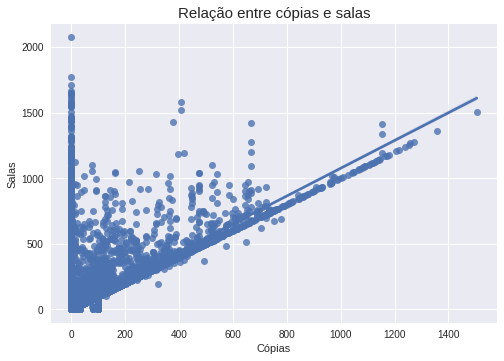

In [ ]:
sns.regplot(data = df, x = 'copias', y = 'salas').set_title('Relação entre cópias e salas', fontsize = 15)
plt.xlabel('Cópias')
plt.ylabel('Salas');

In [ ]:
df.drop(['copias'], axis = 1, inplace = True)

### Criando novos datasets agrupados pela variável titulo_original

Muitos filmes com o mesmo título estão em diferentes linhas devido ao fato de que, como as bilheterias são computadas semana a semana, os mesmos filmes entram mais de uma vez na lista. É possível observar isto no exemplo abaixo com Os Vingadores, em que o mesmo filme aparece 22 vezes.

In [ ]:
df.loc[df['titulo_original'] == 'THE AVENGERS']

,titulo_original,genero,pais_origem,salas,dt_inicio_exibicao,dt_fim_exibicao,publico,renda,razao_social_distribuidora,ano_cinematografico,internacional_nacional,tempo_exibicao
19432,THE AVENGERS,Ficção,Estados Unidos,1042,2012-04-27,2012-05-03,3540885,42865248.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
19548,THE AVENGERS,Ficção,Estados Unidos,1042,2012-05-04,2012-05-10,2416994,28762632.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
19665,THE AVENGERS,Ficção,Estados Unidos,937,2012-05-11,2012-05-17,1631595,19496567.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
19781,THE AVENGERS,Ficção,Estados Unidos,914,2012-05-18,2012-05-24,1279295,15568218.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
19894,THE AVENGERS,Ficção,Estados Unidos,665,2012-05-25,2012-05-31,747787,8655069.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
20002,THE AVENGERS,Ficção,Estados Unidos,747,2012-06-01,2012-06-07,609031,6861170.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
20101,THE AVENGERS,Ficção,Estados Unidos,436,2012-06-08,2012-06-14,354064,3773251.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
20198,THE AVENGERS,Ficção,Estados Unidos,350,2012-06-15,2012-06-21,164956,1656024.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
20294,THE AVENGERS,Ficção,Estados Unidos,205,2012-06-22,2012-06-28,70169,664082.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days
20387,THE AVENGERS,Ficção,Estados Unidos,62,2012-06-29,2012-07-05,17767,173688.0000,THE WALT DISNEY COMPANY (BRASIL) LTDA.,2012,0,6 days


A fim de "somar" os filmes em uma mesma linha, será feito um agrupamento pela variável 'título_original'

In [ ]:
tempo_exibicao2 = df.groupby('titulo_original')['tempo_exibicao'].sum()

df2 = pd.DataFrame(tempo_exibicao2)
df2 = df2.sort_values(by = 'tempo_exibicao', ascending = False)

In [ ]:
renda2 = df.groupby('titulo_original')['renda'].sum()
df3 = pd.DataFrame(renda2)

pd.options.display.float_format = '{:.4f}'.format

df3 = df3.sort_values(by = 'renda', ascending = False) 

In [ ]:
publico2 = df.groupby('titulo_original')['publico'].sum()

df4 = pd.DataFrame(publico2)
df4 = df4.sort_values(by = 'publico', ascending = False)

In [ ]:
salas2 = df.groupby('titulo_original')['salas'].sum()

df5= pd.DataFrame(salas2)
df5 = df5.sort_values(by = 'salas', ascending = False)

In [ ]:
ano2 = df.groupby('titulo_original')['ano_cinematografico'].max()
df6 = pd.DataFrame(ano2)
df6 = df6.sort_values(by = 'ano_cinematografico', ascending = False)

In [ ]:
distribuidora2 = df[['titulo_original', 'razao_social_distribuidora']]
df7 = pd.DataFrame(distribuidora2)
df7.drop_duplicates(subset = 'titulo_original', inplace = True)

In [ ]:
genero2= df[['titulo_original', 'genero']]
df8=pd.DataFrame(genero2)
df8.drop_duplicates(subset = 'titulo_original', inplace = True)

In [ ]:
internacional_nacional2 = df[['titulo_original', 'internacional_nacional']]
df9 = pd.DataFrame(internacional_nacional2)
df9.drop_duplicates(subset = 'titulo_original', inplace = True)

In [ ]:
# Unindo os dataframes

data_frames = [df4, df2, df3, df5, df6, df7, df8, df9]

df_merged = reduce(lambda  left, right: pd.merge(left, right, on = ['titulo_original'], how = 'outer'), data_frames)

In [ ]:
# Observando o dataser criado

df_merged.head()

,titulo_original,publico,tempo_exibicao,renda,salas,ano_cinematografico,razao_social_distribuidora,genero,internacional_nacional
0,OS DEZ MANDAMENTOS,11305479,222 days,116833026.8800,7319,2016,SM DISTRIBUIDORA DE FILMES LTDA,Ficção,1
1,TROPA DE ELITE 2,11146723,168 days,103461153.7400,6240,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,Ficção,1
2,THE AVENGERS,10911371,132 days,129595590.0000,6693,2012,THE WALT DISNEY COMPANY (BRASIL) LTDA.,Ficção,0
3,THE AVENGERS: AGE OF ULTRON,10129071,132 days,146184931.0000,7881,2015,THE WALT DISNEY COMPANY (BRASIL) LTDA.,Ficção,0
4,FURIOUS SEVEN,9857968,138 days,142466037.0200,5961,2016,COLUMBIA TRISTAR FILMES DO BRASIL LTDA,Ficção,0


In [ ]:
# Verificando se o problema foi resolvido com o mesmo exemplo de Os Vingadores

df_merged.loc[df_merged['titulo_original'] == 'THE AVENGERS']

,titulo_original,publico,tempo_exibicao,renda,salas,ano_cinematografico,razao_social_distribuidora,genero,internacional_nacional
2,THE AVENGERS,10911371,132 days,129595590.0000,6693,2012,THE WALT DISNEY COMPANY (BRASIL) LTDA.,Ficção,0


## Respondendo perguntas propostas

###**O mercado de filmes está crescendo ou diminuindo?**

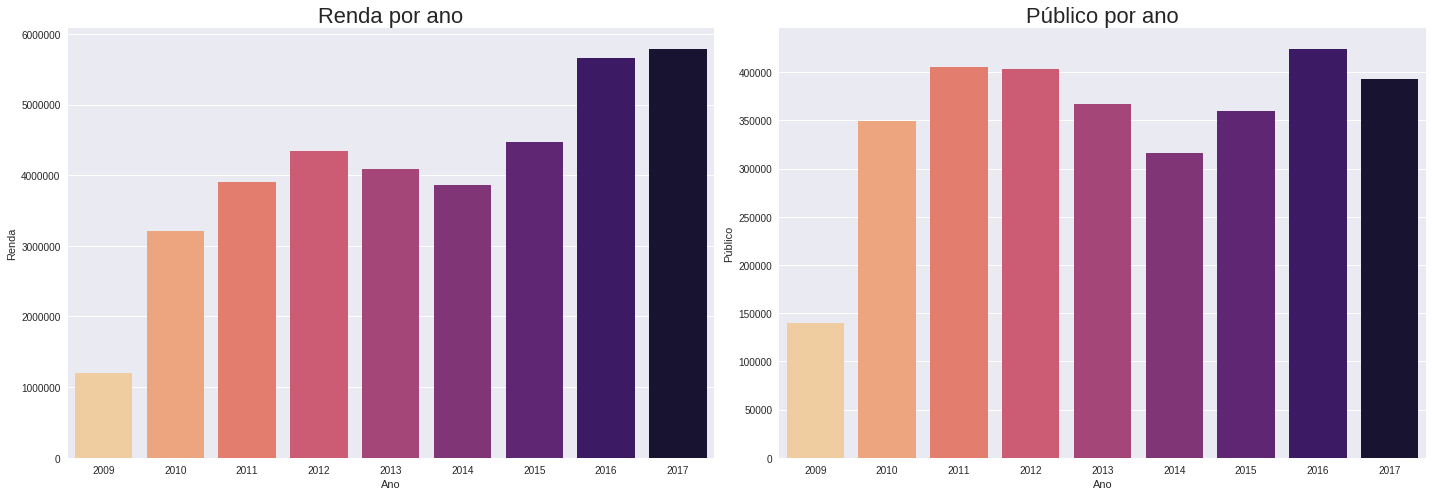

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_merged,
            x = 'ano_cinematografico',
            y = 'renda',
            ci = None,
            palette = 'magma_r').set_title("Renda por ano", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Renda')
axes[0].ticklabel_format(axis = "y", style = 'plain')

sns.barplot(ax = axes[1],
            data = df_merged,
            x = 'ano_cinematografico',
            y = 'publico',
            ci = None,
            palette = 'magma_r').set_title("Público por ano", fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Público')

plt.tight_layout()
plt.show()

In [412]:
# Calculando a taxa de crescimento da renda

taxa_renda = df_merged.groupby('ano_cinematografico')['renda'].sum()
taxa_renda = taxa_renda.reset_index(name = 'renda')

taxas_calculadas_renda = []
posicao_1 = 0
posicao_2 = 1

if taxa_renda.ano_cinematografico[0] == 2009:
  taxas_calculadas_renda.append(0)

for valor in taxa_renda.renda:
  if posicao_2 == 9:
    break
  else:
    diferenca = taxa_renda['renda'][posicao_2] - taxa_renda['renda'][posicao_1]
    divisao = diferenca/taxa_renda['renda'][posicao_1]
    porcentagem = divisao*100
    taxas_calculadas_renda.append(porcentagem)
    posicao_1 += 1
    posicao_2 += 1

In [417]:
# Calculando a taxa de crescimento do público

taxa_publico = df_merged.groupby('ano_cinematografico')['publico'].sum()
taxa_publico = taxa_publico.reset_index(name = 'publico')

taxas_calculadas_publico = []
posicao_1 = 0
posicao_2 = 1

if taxa_publico.ano_cinematografico[0] == 2009:
  taxas_calculadas_publico.append(0)

for valor in taxa_publico.publico:
  if posicao_2 == 9:
    break
  else:
    diferenca = taxa_publico['publico'][posicao_2] - taxa_publico['publico'][posicao_1]
    divisao = diferenca/taxa_publico['publico'][posicao_1]
    porcentagem = divisao*100
    taxas_calculadas_publico.append(porcentagem)
    posicao_1 += 1
    posicao_2 += 1

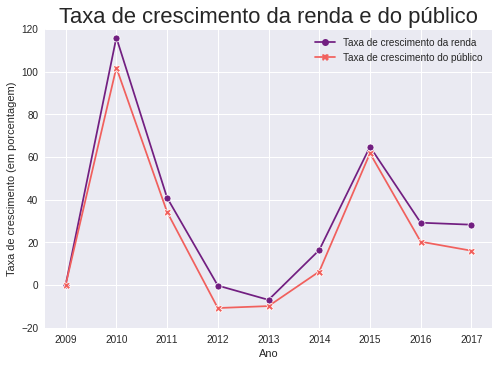

In [ ]:
# Como não possuímos dados anteriores a 2009, colocamos a taxa de crescimento de 2009 em 0

taxas = {'Ano': list(range(2009, 2018)),
         'Taxa de crescimento da renda': taxas_calculadas_renda,
         'Taxa de crescimento do público': taxas_calculadas_publico}
taxas = pd.DataFrame(taxas)
taxas = taxas.set_index('Ano')
sns.lineplot(data = taxas, palette = 'magma', markers = True, dashes = False).set_title('Taxa de crescimento da renda e do público',
                                                                                         fontsize = 22, fontweight = 200)
plt.ylim(-20, 120)
plt.ylabel('Taxa de crescimento (em porcentagem)');

Do ponto de vista da renda e da audiência, o mercado de filmes cresceu entre 2009 e 2017.

A taxa de crescimento da renda foi de quase 300% do primeiro para o último ano e a taxa de crescimento da renda e do público em relação ao ano anterior só foi negativa em 2012 e 2013, voltando a crescer nos anos seguintes com destaque para o crescimento ocorrido no ano de 2015.

No Brasil, os anos de 2013 e 2014 foram difíceis para a economia, começamos a sentir com mais força a crise financeira de 2008, provavelmente havendo alguma relação.

Já em 2015, lançaram filmes de grande sucesso, como por exemplo:
- Divertida Mente
- Star Wars: O Despertar da Força
- Velozes & Furiosos 7
- Mad Max: Estrada da Fúria
- Vingadores: Era de Ultron

### **A teoria da Juliana que os filmes nacionais têm tido cada vez mais aceitação é verdade?**

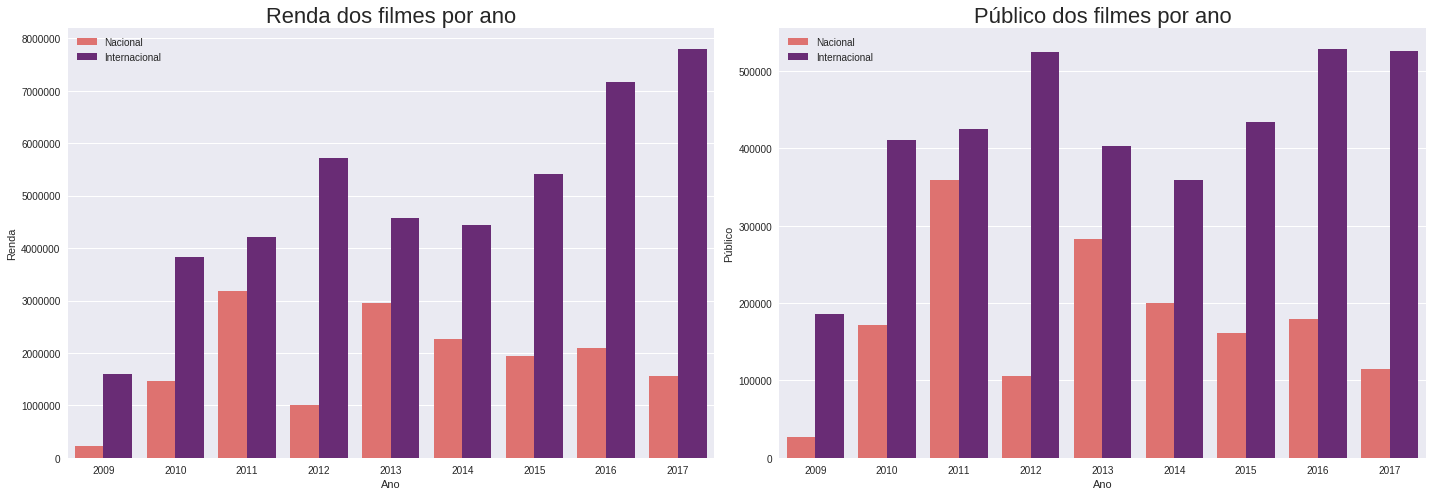

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_merged,
            x = 'ano_cinematografico',
            y = 'renda',
            hue = 'internacional_nacional',
            ci = None,
            palette = 'magma_r').set_title("Renda dos filmes por ano", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Renda')
axes[0].ticklabel_format(axis = "y", style = 'plain')
axes[0].legend(np.arange(2), labels = ['Nacional', 'Internacional'])

sns.barplot(ax = axes[1],
            data = df_merged,
            x = 'ano_cinematografico',
            y = 'publico',
            hue = 'internacional_nacional',
            ci = None,
            palette = 'magma_r').set_title("Público dos filmes por ano", fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Público')
axes[1].legend(np.arange(2), labels = ['Nacional', 'Internacional'])

plt.tight_layout()
plt.show()

In [ ]:
# Criando um novo df apenas com filmes nacionais

df_filmes_nacionais = df_merged.loc[(df_merged.internacional_nacional == '1')]
df_filmes_nacionais.head()

,titulo_original,publico,tempo_exibicao,renda,salas,ano_cinematografico,razao_social_distribuidora,genero,internacional_nacional
0,OS DEZ MANDAMENTOS,11305479,222 days,116833026.8800,7319,2016,SM DISTRIBUIDORA DE FILMES LTDA,Ficção,1
1,TROPA DE ELITE 2,11146723,168 days,103461153.7400,6240,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,Ficção,1
8,MINHA MÃE É UMA PEÇA 2,9234363,108 days,124681177.8200,6462,2017,FREESPIRIT DISTRIBUIDORA DE FILMES LTDA.,Ficção,1
35,SE EU FOSSE VOCÊ 2,5787244,264 days,47624137.0000,4162,2010,FOX FILM DO BRASIL LTDA,Ficção,1
51,DE PERNAS PRO AR 2,4846273,90 days,50312134.3600,4050,2013,FREESPIRIT DISTRIBUIDORA DE FILMES LTDA.,Ficção,1


In [419]:
# Calculando a taxa de crescimento da renda

taxa_renda = df_filmes_nacionais.groupby('ano_cinematografico')['renda'].sum()
taxa_renda = taxa_renda.reset_index(name = 'renda')

taxas_calculadas_renda = []
posicao_1 = 0
posicao_2 = 1

if taxa_renda.ano_cinematografico[0] == 2009:
  taxas_calculadas_renda.append(0)

for valor in taxa_renda.renda:
  if posicao_2 == 9:
    break
  else:
    diferenca = taxa_renda['renda'][posicao_2] - taxa_renda['renda'][posicao_1]
    divisao = diferenca/taxa_renda['renda'][posicao_1]
    porcentagem = divisao*100
    taxas_calculadas_renda.append(porcentagem)
    posicao_1 += 1
    posicao_2 += 1

In [421]:
# Calculando a taxa de crescimento do público

taxa_publico = df_filmes_nacionais.groupby('ano_cinematografico')['publico'].sum()
taxa_publico = taxa_publico.reset_index(name = 'publico')

taxas_calculadas_publico = []
posicao_1 = 0
posicao_2 = 1

if taxa_publico.ano_cinematografico[0] == 2009:
  taxas_calculadas_publico.append(0)

for valor in taxa_publico.publico:
  if posicao_2 == 9:
    break
  else:
    diferenca = taxa_publico['publico'][posicao_2] - taxa_publico['publico'][posicao_1]
    divisao = diferenca/taxa_publico['publico'][posicao_1]
    porcentagem = divisao*100
    taxas_calculadas_publico.append(porcentagem)
    posicao_1 += 1
    posicao_2 += 1

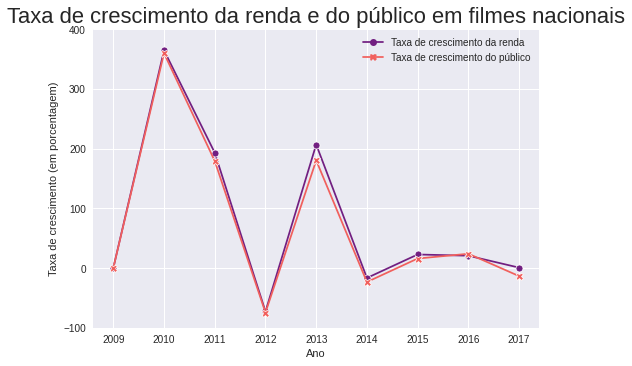

In [ ]:
# Como não possuímos dados anteriores a 2009, colocamos a taxa de crescimento de 2009 em 0

taxas = {'Ano': list(range(2009, 2018)),
         'Taxa de crescimento da renda': taxas_calculadas_renda,
         'Taxa de crescimento do público': taxas_calculadas_publico}
taxas = pd.DataFrame(taxas)
taxas = taxas.set_index('Ano')
sns.lineplot(data = taxas, palette = 'magma', markers = True, dashes = False).set_title('Taxa de crescimento da renda e do público em filmes nacionais',
                                                                        fontsize = 22, fontweight = 200)
plt.ylim(-100, 401)
plt.ylabel('Taxa de crescimento (em porcentagem)');

Com relação a público e renda, a tendência geral ao longo dos anos não parece tão positiva.

O rendimento médio anual apresenta oscilações entre 2009 e 2017, sempre em desvantagem com relação aos títulos internacionais. Os picos em 2011 e 2013 podem ser explicados por alguns títulos de sucesso, como Tropa de Elite 2 (2011), De Pernas pro Ar 2 e Minha Mãe é Uma Peça (ambos de 2013). Apesar do filme de maior público em 2016 ter sido nacional (Os Dez Mandamentos), assim como o rentável em 2017 (Minha Mãe é Uma Peça 2), nesses mesmos anos não tivemos outros grandes sucessos nacionais de bilheteria.

Podemos perceber que o padrão de público acompanha aquele dos rendimentos. Do ponto de visto do desempenho das distribuidoras, por outro lado, talvez seja possível delinear um cenário de crescimento.

Dentre as distribuidoras com rendimento médio individual acima de 10 milhões de reais para todo o período — apenas uma é brasileira. A Zazen Produções é responsável por títulos como Tropa de Elite (2007) e Tropa de Elite 2 (2010) — embora estes tenham sido os únicos lançamentos de maior sucesso de bilheteria da distribuidora. Apesar disso, 11 das três distribuidoras com rendimento médio entre 1 milhão até 10 milhões de reais são brasileiras (levando em consideração a série temporal de 2010 a 2017). Outro ponto positivo é a produção e distribuição de filmes nacionais por grandes distribuidoras internacionais, como a Fox Filmes do Brasil. Essa última é responsável pelo lançamento de Se eu Fosse Você 2 (2010), que rendeu quase 48 mi de reais nesse ano.

Entre as distribuidoras brasileiras que acumulam alguns sucessos, os rendimentos ano a ano demonstram oscilações, mas tomadas em conjunto a perspectiva pode ser positiva. A Downtown Filmes, por exemplo, se recuperou de uma fase ruim entre 2016 e 2017, saltando de um rendimento de cerca de 7 milhões para 21 milhões de reais. O último ano foi o de exibição de Minha Mãe é uma Peça 2, distribuída pela Downtown em conjunto com a Paris Filmes. Essa última distribuidora é a responsável por Os Dez Mandamentos (2016). Infelizmente, 2017 apresentou queda brusca nos rendimentos da Paris Filmes, que não ultrapassou a marca dos 6 milhões em retorno, o que corresponde a menos de um terço dos rendimentos do ano anterior. Há ainda a novata H20 Distribuidora, fundada em 2012. Ela passou de um rendimento anual inferior a 500 mil reais entre 2013 e 2014 para um que superou 11 milhões em 2014. Desde então, apresenta trajetória de crescimento (com exceção de 2016).

Em conclusão, com o grande sucesso de alguns títulos nacionais — que inclusive superou o de filmes internacionais em 2011 com Tropa de Elite 2, há motivos para apostar na aceitação do público. O amadurecimento e especialização crescente das distribuidoras nacionais, somada à firmação de parcerias com produtoras internacionais experientes e bem sucedidas em ascensão, poderíamos esperar receptividade do público. Vale lembrar que somente 30% dos filmes entre 2009 e 2017 apresentam rendimento médio acima de 1 milhão de reais. Portanto, no cotidiano são os filmes de menor rendimento que devem circular nas salas de exibição. Dada a obrigatoriedade de exibição de uma cota mínima de filmes nacionais, a escolha com base em distribuidoras mais consolidadas pode ser uma medida mais segura do retorno dos filmes.


### **Existe algum padrão em filmes que tem alta renda?**

In [ ]:
# Criando um subset com os titulos e a renda

filme_e_renda = df_merged.groupby('titulo_original')['renda'].sum()
filme_e_renda = filme_e_renda.reset_index(name = 'renda')
filme_e_renda = filme_e_renda.sort_values(by = 'renda', ascending = False)
filme_e_renda = filme_e_renda.head(20) # Selecionando apenas os 20 mais rentáveis

In [ ]:
# Criando um subset com o gênero e a renda

genero_e_renda = df_merged.groupby('genero')['renda'].sum()
genero_e_renda = genero_e_renda.reset_index(name = 'renda')
genero_e_renda = genero_e_renda.sort_values(by = 'renda', ascending = False)

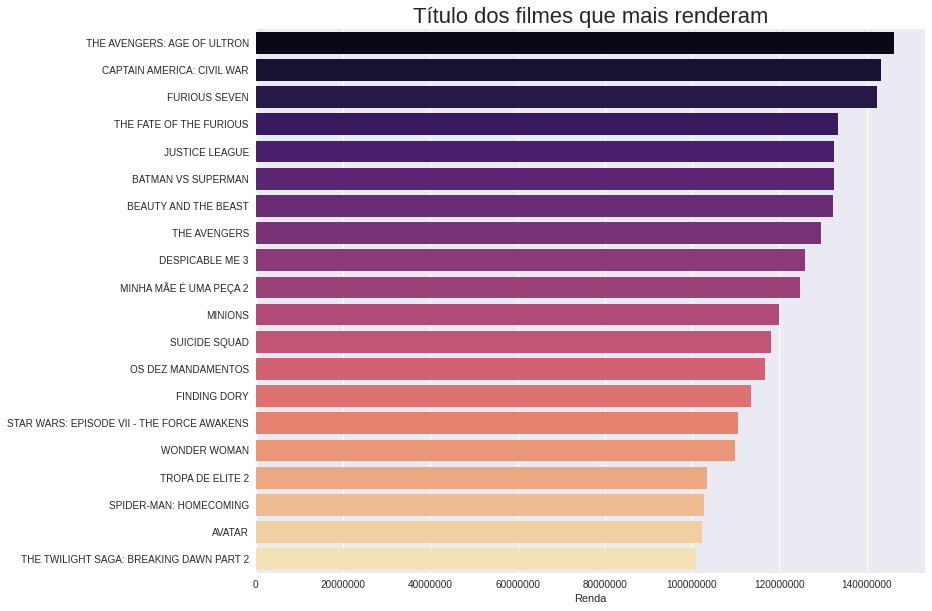

In [ ]:
plt.figure(figsize=(12,10))

sns.barplot(data = filme_e_renda,
            x = 'renda',
            y = 'titulo_original',
            palette = 'magma')
plt.ticklabel_format(axis = "x", style = 'plain')
plt.xlabel('Renda')
plt.ylabel('')
plt.title('Título dos filmes que mais renderam', fontsize = 22, fontweight = 200);

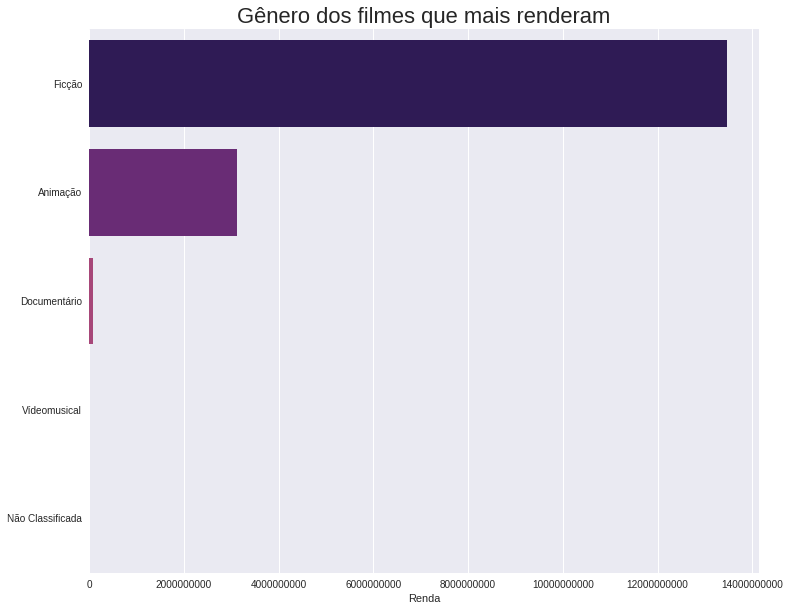

In [ ]:
plt.figure(figsize=(12,10))

sns.barplot(data = genero_e_renda,
            x = 'renda',
            y = 'genero',
            palette = 'magma')
plt.xlabel('Renda')
plt.ylabel('')
plt.ticklabel_format(axis = "x", style = 'plain')
plt.title('Gênero dos filmes que mais renderam', fontsize = 22, fontweight = 200);

Os filmes que possuem alta renda são majoritariamente de ficção. Isto pode ser devido ao sucesso estrondoso dos filmes de herói, principalmente da Marvel.

### **Existem distribuidoras que trazem filmes com mais renda?**

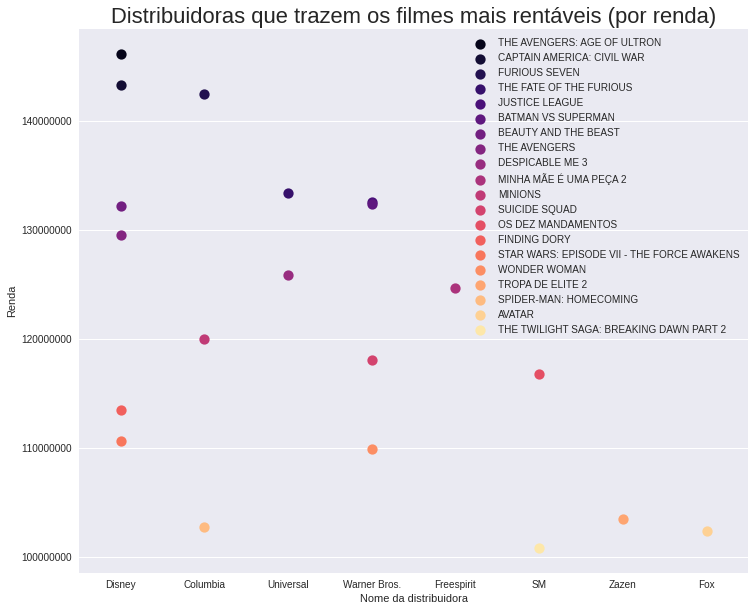

In [ ]:
plt.figure(figsize = (12,10))

df_merged = df_merged.sort_values(by ='renda', ascending=False)
df2 = df_merged.head(20)

sns.pointplot(data = df2,
              x = 'razao_social_distribuidora',
              y = 'renda',
              hue = 'titulo_original',
              palette = 'magma').set_title('Distribuidoras que trazem os filmes mais rentáveis (por renda)', fontsize = 22, fontweight = 200)
plt.ticklabel_format(axis = "y", style = 'plain')
plt.xticks(np.arange(8), ['Disney', 'Columbia', 'Universal', 'Warner Bros.', 'Freespirit', 'SM', 'Zazen', 'Fox'])
plt.legend()
plt.xlabel('Nome da distribuidora')
plt.ylabel('Renda');

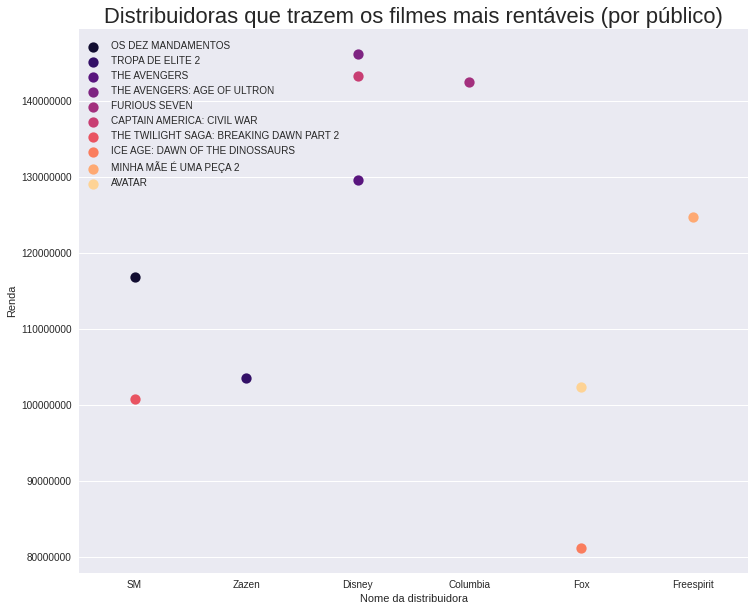

In [ ]:
plt.figure(figsize = (12,10))

df_merged = df_merged.sort_values(by ='publico', ascending=False)
df2 = df_merged.head(10)

sns.pointplot(data = df2,
              x = 'razao_social_distribuidora',
              y = 'renda',
              hue = 'titulo_original',
              palette = 'magma').set_title('Distribuidoras que trazem os filmes mais rentáveis (por público)', fontsize = 22, fontweight = 200)
plt.ticklabel_format(axis = "y", style = 'plain')
plt.xticks(np.arange(6), ['SM', 'Zazen', 'Disney', 'Columbia', 'Fox', 'Freespirit'])
plt.legend(loc = (0, 0.7))
plt.xlabel('Nome da distribuidora')
plt.ylabel('Renda');

É possível perceber que os mais rentáveis são os internacionais, com a exceção de Minha Mãe é Uma Peça 2 em 10º lugar.

Porém, quando vamos por público, além do Minha Mãe é Uma Peça 2 que continua aparencendo, os 2 primeiros lugares são filmes nacionais, podendo concluir que filmes nacionais geram menos renda mesmo quando têm mais público.

### **Criação de uma sala VIP com 100 lugares com preço do ingresso 30% mais caro**

In [ ]:
# Como não possuímos o valor do preço do ingresso médio, será feita uma estimativa com as variáveis renda e publico

df_merged['preco_medio_ingresso'] = df_merged['renda']/df_merged['publico']

In [ ]:
# Observando a relação entre o ano e o preço médio do ingresso

ano_ingresso = df_merged.groupby('ano_cinematografico')['preco_medio_ingresso'].mean()
ano_ingresso

ano_cinematografico
2009    6.6804
2010    8.5674
2011    8.9086
2012    9.8817
2013   11.2192
2014   11.7542
2015   12.8866
2016   13.7035
2017   13.9289
Name: preco_medio_ingresso, dtype: float64

In [ ]:
# Observando a relação entre o ano e a renda

ano_renda = df_merged.groupby('ano_cinematografico')['renda'].mean()
ano_renda

ano_cinematografico
2009   1199704.2471
2010   3210243.8016
2011   3908882.5127
2012   4343138.7772
2013   4081238.5173
2014   3854735.2168
2015   4469782.6039
2016   5652003.1604
2017   5787881.6980
Name: renda, dtype: float64

In [ ]:
# Observando a relação entre o ano e o público

ano_publico = df_merged.groupby('ano_cinematografico')['publico'].mean()
ano_publico

ano_cinematografico
2009   139699.1640
2010   349464.0295
2011   405395.0113
2012   402946.4038
2013   366799.6592
2014   316493.9535
2015   360147.5218
2016   424096.7900
2017   393056.6420
Name: publico, dtype: float64

Uma nova sala com 100 lugares significa um aumento de aproximadamente 43% da capacidade total do cinema. Para no mínimo manter a taxa de crescimento da renda anual, o cinema precisaria, então, de um crescimento de 43% do público (cerca de 169.015 pessoas a mais anualmente) em relação ao ano anterior, caso o valor do ingresso fosse o mesmo (segundo a média: aproximadamente 14 reais). No entanto, como a nova sala cobra 30% a mais no ingresso (18 reais), então o crescimento de público poderia ser de "apenas" 33,4% - para se manter a taxa de crescimento anual da renda. No entanto, essa taxa de crescimento é muito alta e não parece que se verificar tal tendência (calculada anteriormente).

Como um exemplo de impacto negativo quando se aumenta o preço do ingresso, tem-se que a de 2016 para 2017, o preço do ingresso subiu aproximadamente 0.2254 reais. Apesar da renda ter subido de um ano para o outro, o público diminuiu, tendo uma defasagem de aproximadamente 31040 pessoas

### **Existe algum padrão para filmes que ficam mais tempo em cartaz do que outros?**

In [ ]:
df_merged_exibicao = df_merged.sort_values(by ='tempo_exibicao', ascending = False)

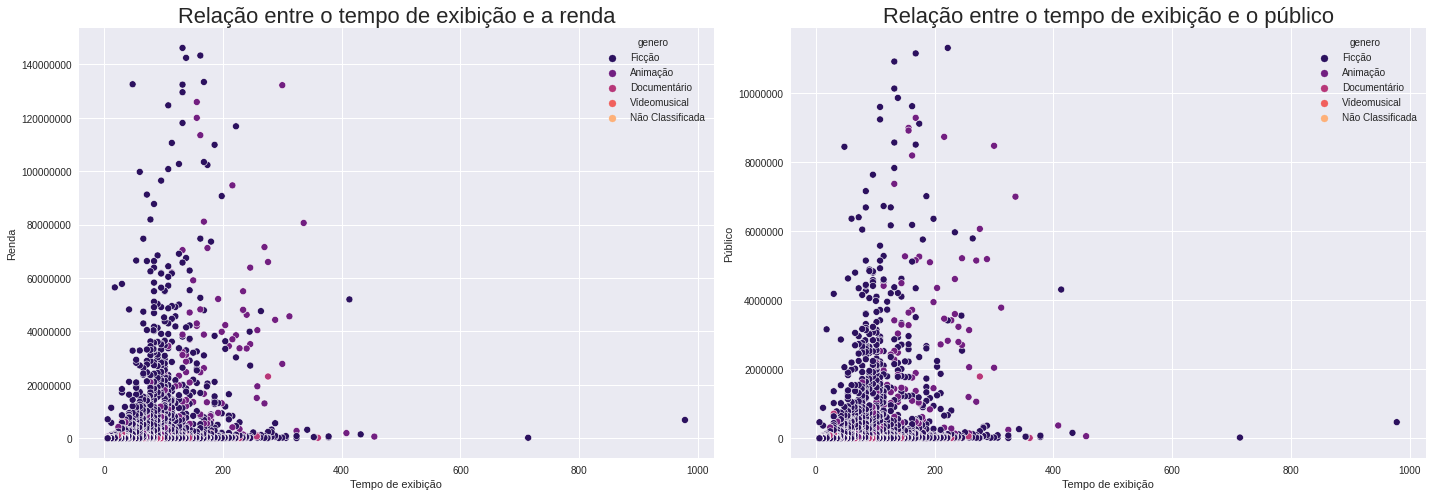

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.scatterplot(ax = axes[0],
                data = df_merged_exibicao,
                x = 'tempo_exibicao',
                y = 'renda',
                hue = 'genero',
                palette = 'magma').set_title("Relação entre o tempo de exibição e a renda (por gênero)", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Tempo de exibição')
axes[0].set_ylabel('Renda')
axes[0].ticklabel_format(axis = "y", style = 'plain')

sns.scatterplot(ax = axes[1],
                data = df_merged_exibicao,
                x = 'tempo_exibicao',
                y = 'publico',
                hue = 'genero',
                palette = 'magma').set_title("Relação entre o tempo de exibição e o público (por gênero)", fontsize = 22, fontweight = 200)
axes[1].ticklabel_format(axis = "y", style = 'plain')
axes[1].set_xlabel('Tempo de exibição')
axes[1].set_ylabel('Público')

plt.tight_layout()
plt.show()

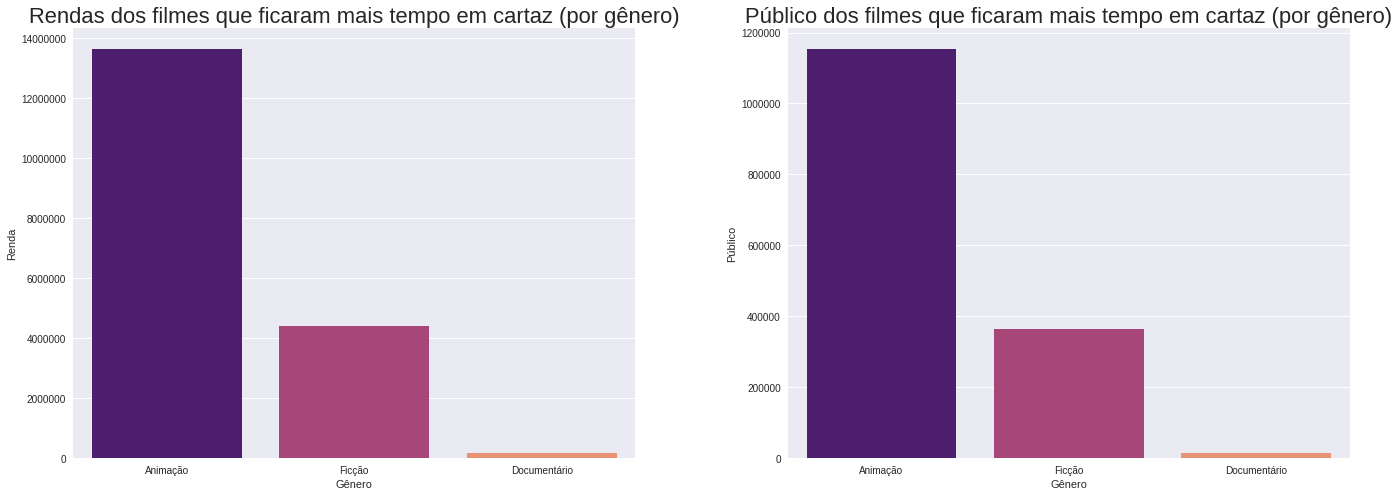

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_merged_exibicao,
            x = 'genero',
            order = ['Animação', 'Ficção', 'Documentário'],
            y = 'renda',
            ci = None,
            palette = 'magma').set_title("Rendas dos filmes que ficaram mais tempo em cartaz (por gênero)", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Gênero')
axes[0].set_ylabel('Renda')
axes[0].ticklabel_format(axis = "y", style = 'plain')

sns.barplot(ax = axes[1],
            data = df_merged_exibicao,
            x = 'genero',
            order = ['Animação', 'Ficção', 'Documentário'],
            y = 'publico',
            ci = None,
            palette = 'magma').set_title("Público dos filmes que ficaram mais tempo em cartaz (por gênero)", fontsize = 22, fontweight = 200)
axes[1].ticklabel_format(axis = "y", style = 'plain')
axes[1].set_xlabel('Gênero')
axes[1].set_ylabel('Público')

plt.tight_layout()
plt.show()

É possível notar que os gêneros que mais se destacam são de animação e ficção. Será realizada uma análise mais detalhada com eles.

In [ ]:
df_merged['tempo_exibicao'] = df_merged['tempo_exibicao'].dt.days

In [ ]:
# Separando os datasets

df_animacao = df_merged.loc[df_merged['genero'] == 'Animação']
df_ficcao = df_merged.loc[df_merged['genero'] == 'Ficção']

In [368]:
# Separação pelo tempo em exibição

df_animacao_tempo = df_animacao.sort_values(by ='tempo_exibicao', ascending = False)
df_animacao_tempo = df_animacao_tempo.head(20)

df_ficcao_tempo = df_ficcao.sort_values(by ='tempo_exibicao', ascending = False)
df_ficcao_tempo = df_ficcao_tempo.head(20)

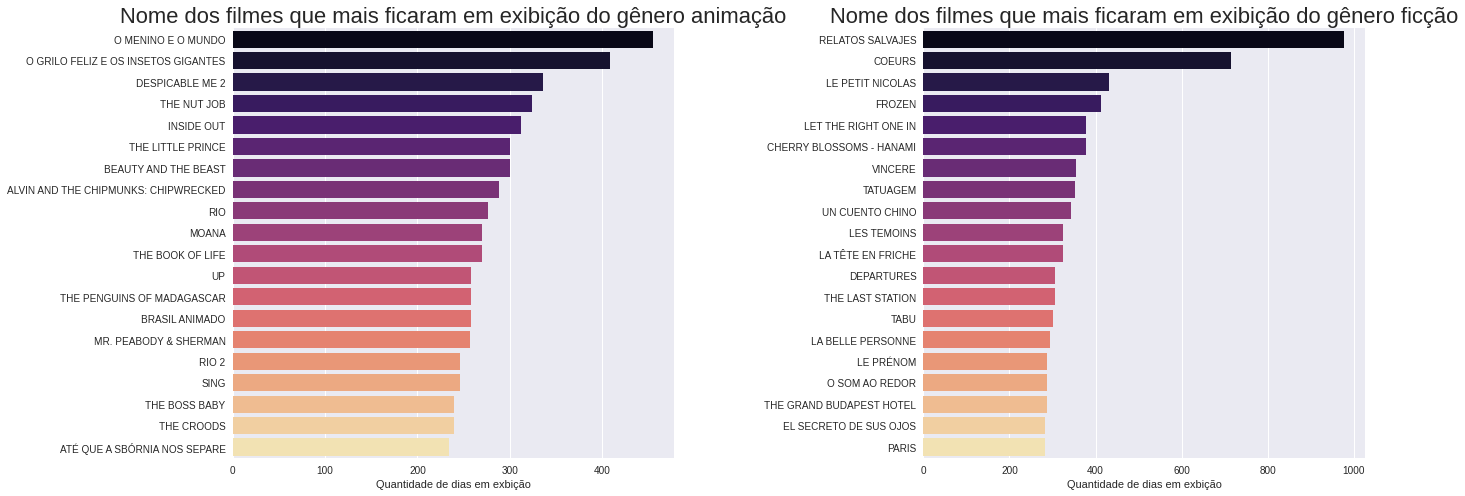

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_animacao_tempo,
            x = 'tempo_exibicao',
            y = 'titulo_original',
            palette = 'magma').set_title("Nome dos filmes que mais ficaram em exibição do gênero animação", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Quantidade de dias em exbição')
axes[0].set_ylabel('')

sns.barplot(ax = axes[1],
            data = df_ficcao_tempo,
            x = 'tempo_exibicao',
            y = 'titulo_original',
            palette = 'magma').set_title("Nome dos filmes que mais ficaram em exibição do gênero ficção", fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Quantidade de dias em exbição')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Separação pela renda

df_animacao_renda = df_animacao.sort_values(by ='renda', ascending = False)
df_animacao_renda = df_animacao_renda.head(20)

df_ficcao_renda = df_ficcao.sort_values(by ='renda', ascending = False)
df_ficcao_renda = df_ficcao_renda.head(20)

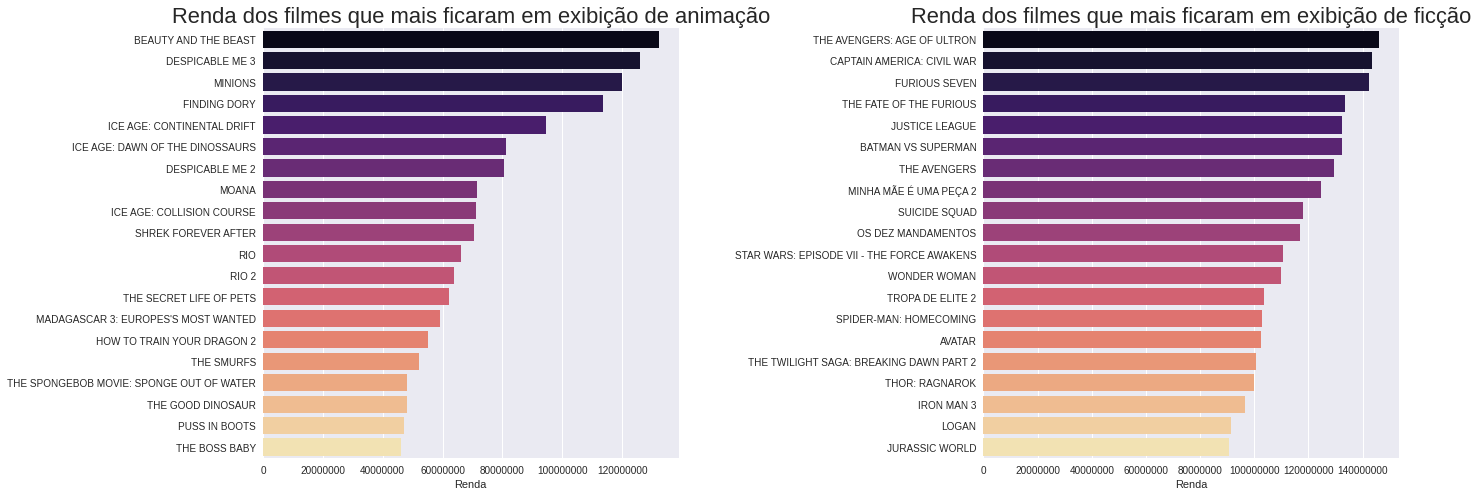

In [354]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_animacao_renda,
            x = 'renda',
            y = 'titulo_original',
            palette = 'magma').set_title("Renda dos filmes que mais ficaram em exibição de animação", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Renda')
axes[0].set_ylabel('')
axes[0].ticklabel_format(axis = "x", style = 'plain')

sns.barplot(ax = axes[1],
            data = df_ficcao_renda,
            x = 'renda',
            y = 'titulo_original',
            palette = 'magma').set_title("Renda dos filmes que mais ficaram em exibição de ficção", fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Renda')
axes[1].set_ylabel('')
axes[1].ticklabel_format(axis = "x", style = 'plain')

plt.tight_layout()
plt.show()

In [395]:
# Separando as distribuidoras mais exibidas

df_dist_exibidas_animacao = df_animacao.groupby('razao_social_distribuidora')['tempo_exibicao'].sum()
df_dist_exibidas_animacao = df_dist_exibidas_animacao.reset_index(name = 'tempo_exibicao')
df_dist_exibidas_animacao = df_dist_exibidas_animacao.sort_values(by = 'tempo_exibicao', ascending = False)
df_dist_exibidas_animacao = df_dist_exibidas_animacao.head(20)

df_dist_exibidas_ficcao = df_ficcao.groupby('razao_social_distribuidora')['tempo_exibicao'].sum()
df_dist_exibidas_ficcao = df_dist_exibidas_ficcao.reset_index(name = 'tempo_exibicao')
df_dist_exibidas_ficcao = df_dist_exibidas_ficcao.sort_values(by = 'tempo_exibicao', ascending = False)
df_dist_exibidas_ficcao = df_dist_exibidas_ficcao.head(20)

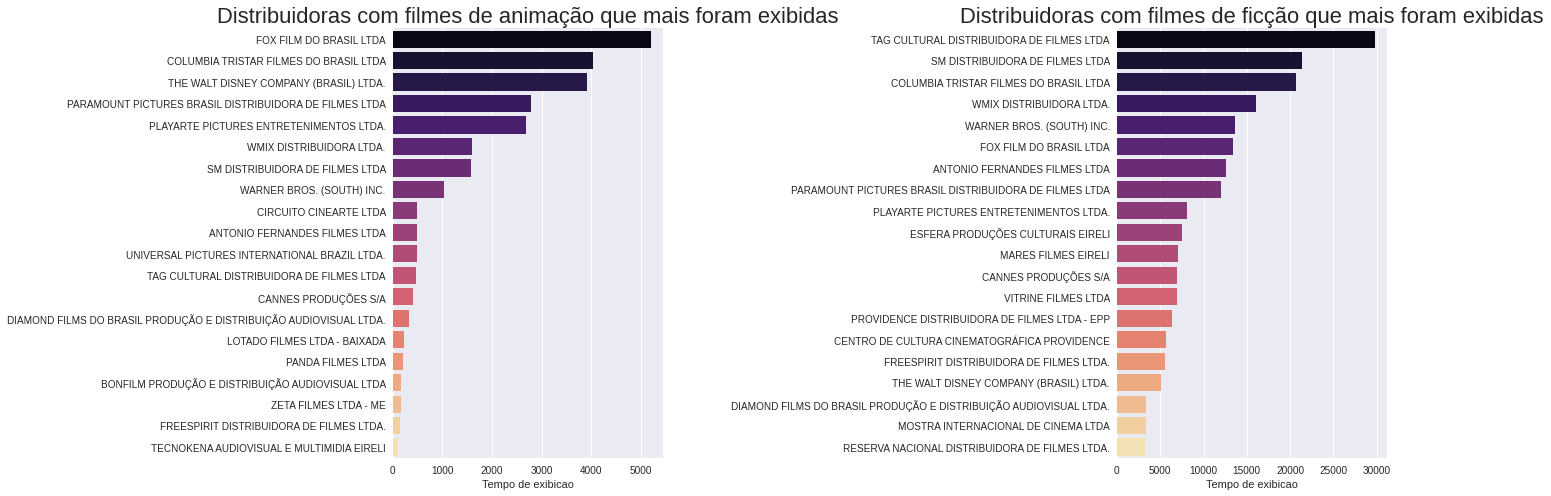

In [404]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_dist_exibidas_animacao,
            x = 'tempo_exibicao',
            y = 'razao_social_distribuidora',
            palette = 'magma').set_title("Distribuidoras com filmes de animação que mais foram exibidas", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Tempo de exibicao')
axes[0].set_ylabel('')
axes[0].ticklabel_format(axis = "x", style = 'plain')

sns.barplot(ax = axes[1],
            data = df_dist_exibidas_ficcao,
            x = 'tempo_exibicao',
            y = 'razao_social_distribuidora',
            palette = 'magma').set_title("Distribuidoras com filmes de ficção que mais foram exibidas", fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Tempo de exibicao')
axes[1].set_ylabel('')
axes[1].ticklabel_format(axis = "x", style = 'plain')

plt.tight_layout()
plt.show()

In [399]:
# Separando as distribuidoras mais rentaveis

df_dist_rentaveis_animacao = df_animacao.groupby('razao_social_distribuidora')['renda'].sum()
df_dist_rentaveis_animacao = df_dist_rentaveis_animacao.reset_index(name = 'renda')
df_dist_rentaveis_animacao = df_dist_rentaveis_animacao.sort_values(by = 'renda', ascending = False)
df_dist_rentaveis_animacao = df_dist_rentaveis_animacao.head(10)

df_dist_rentaveis_ficcao = df_ficcao.groupby('razao_social_distribuidora')['renda'].sum()
df_dist_rentaveis_ficcao = df_dist_rentaveis_ficcao.reset_index(name = 'renda')
df_dist_rentaveis_ficcao = df_dist_rentaveis_ficcao.sort_values(by = 'renda', ascending = False)
df_dist_rentaveis_ficcao = df_dist_rentaveis_ficcao.head(10)

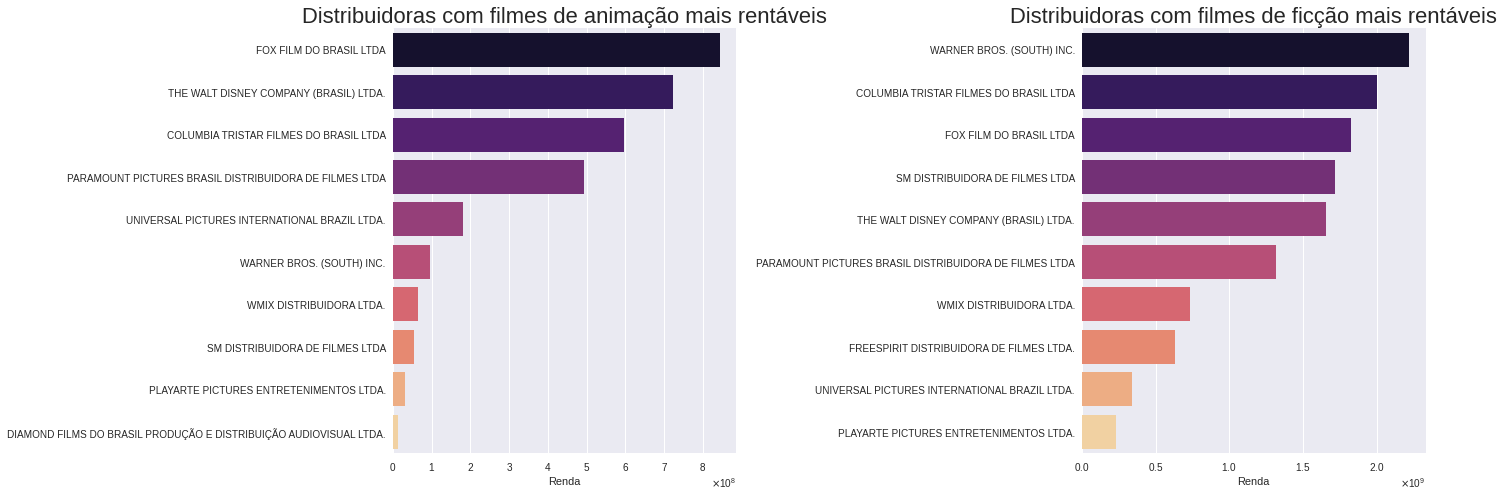

In [411]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_dist_rentaveis_animacao,
            x = 'renda',
            y = 'razao_social_distribuidora',
            palette = 'magma').set_title("Distribuidoras com filmes de animação mais rentáveis", fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Renda')
axes[0].set_ylabel('')
axes[0].ticklabel_format(axis = "x", useMathText = True)

sns.barplot(ax = axes[1],
            data = df_dist_rentaveis_ficcao,
            x = 'renda',
            y = 'razao_social_distribuidora',
            palette = 'magma').set_title("Distribuidoras com filmes de ficção mais rentáveis", fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Renda')
axes[1].set_ylabel('')
axes[1].ticklabel_format(axis = "x", useMathText = True)

plt.tight_layout()
plt.show()

Algo interessante de se notar é que não necessariamente mais tempo em exibição significa uma renda maior, como foi possível ver anteriormente.

## Insights adicionais

Será feito um agrupamento das distribuidoras em 3 categorias (alta, média e baixa renda), segundo o rendimento arrecadado ao longo do período e a criação de duas categorizações de renda: detalhada e binária.

In [ ]:
# Separando as distribuidoras por renda

dist_dict = {
'UNIVERSAL PICTURES INTERNATIONAL BRAZIL LTDA.': 'major',
'THE WALT DISNEY COMPANY (BRASIL) LTDA.': 'major',
'ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.': 'major',
'FOX FILM DO BRASIL LTDA': 'major',
'WARNER BROS. (SOUTH) INC.': 'major',
'PARAMOUNT PICTURES BRASIL DISTRIBUIDORA DE FILMES LTDA': 'major',
'COLUMBIA TRISTAR FILMES DO BRASIL LTDA': 'media',
'FREESPIRIT DISTRIBUIDORA DE FILMES LTDA.': 'media',
'SM DISTRIBUIDORA DE FILMES LTDA': 'media',
'CANZION DO BRASIL LTDA': 'media',
'H2O DISTRIBUIDORA DE FILMES LTDA': 'media',
'WMIX DISTRIBUIDORA LTDA.': 'media',
'DIAMOND FILMS DO BRASIL PRODUÇÃO E DISTRIBUIÇÃO AUDIOVISUAL LTDA.': 'media',
'PLAYARTE PICTURES ENTRETENIMENTOS LTDA.': 'media',
'GRAÇA FILMES PRODUTORA E DISTRIBUIDORA LTDA': 'media',
'ELIMAR PRODUÇÕES ARTÍSTICAS LTDA': 'media',
'CUATRO DAMAS FILMES LTDA.': 'media',
'CANNES PRODUÇÕES S/A': 'media',
'CHATO LTDA': 'media'
}

# O valor de corte faz referência aos rendimentos médios das distribuidoras, conforme tabela acima.
# Major: rendimento médio para todo o período acima de 10 milhões de reais;
# Média: rendimento médio de 1 até 10 milhões de reais;
# Menores: rendimento médio abaixo de 1 milhão de reais.

df_merged['distribuidoras'] = df_merged['razao_social_distribuidora'].map(dist_dict).fillna('menores')
df_merged.head(3)

,titulo_original,publico,tempo_exibicao,renda,salas,ano_cinematografico,razao_social_distribuidora,genero,internacional_nacional,preco_medio_ingresso,distribuidoras
580,RELATOS SALVAJES,466869,978,6852253.0000,887,2017,WARNER BROS. (SOUTH) INC.,Ficção,0,14.6770,major
1777,COEURS,21158,714,199822.0800,129,2014,CENTRO DE CULTURA CINEMATOGRÁFICA PROVIDENCE,Ficção,0,9.4443,menores
1296,O MENINO E O MUNDO,61152,455,633901.2500,371,2016,CIRCUITO CINEARTE LTDA,Animação,1,10.3660,menores


In [ ]:
altissimo = len(df_merged[(df_merged['renda'] > 25000000)])
alto = len(df_merged[(df_merged['renda'] <= 25000000) & (df_merged['renda'] > 10000000)])
medio = len(df_merged[(df_merged['renda'] <= 10000000) & (df_merged['renda'] > 1000000)])
baixo = len(df_merged[(df_merged['renda' ] <= 1000000) & (df_merged['renda'] >= 500000)])
baixissimo = len(df_merged[(df_merged['renda'] < 500000)])

In [ ]:
alto = len(df_merged[(df_merged['renda'] >= 1000000)])
baixo = len(df_merged[(df_merged['renda'] < 1000000)])

In [ ]:
conditions = [
    (df_merged['renda'] > 25000000),
    (df_merged['renda'] <= 25000000) & (df_merged['renda'] > 10000000),
    (df_merged['renda'] <= 10000000) & (df_merged['renda'] > 1000000),
    (df_merged['renda'] <= 1000000) & (df_merged['renda'] >= 500000),
    (df_merged['renda'] < 500000)
]

values = ['altissmo', 'alto', 'medio', 'baixo', 'baixissimo']

df_merged['rendacat'] = np.select(conditions, values)

df_merged.head(2)

,titulo_original,publico,tempo_exibicao,renda,salas,ano_cinematografico,razao_social_distribuidora,genero,internacional_nacional,preco_medio_ingresso,distribuidoras,rendacat
580,RELATOS SALVAJES,466869,978,6852253.0000,887,2017,WARNER BROS. (SOUTH) INC.,Ficção,0,14.6770,major,medio
1777,COEURS,21158,714,199822.0800,129,2014,CENTRO DE CULTURA CINEMATOGRÁFICA PROVIDENCE,Ficção,0,9.4443,menores,baixissimo


In [ ]:
df_merged['rendacat'].value_counts()

baixissimo    2425
medio          787
baixo          271
alto           198
altissmo       189
Name: rendacat, dtype: int64

In [ ]:
conditions = [
    (df_merged['renda'] > 1000000),
    (df_merged['renda'] <= 1000000)
]

values = ['alto', 'baixo']

df_merged['rendabinaria'] = np.select(conditions, values)

df_merged.head(2)

,titulo_original,publico,tempo_exibicao,renda,salas,ano_cinematografico,razao_social_distribuidora,genero,internacional_nacional,preco_medio_ingresso,distribuidoras,rendacat,rendabinaria
580,RELATOS SALVAJES,466869,978,6852253.0000,887,2017,WARNER BROS. (SOUTH) INC.,Ficção,0,14.6770,major,medio,alto
1777,COEURS,21158,714,199822.0800,129,2014,CENTRO DE CULTURA CINEMATOGRÁFICA PROVIDENCE,Ficção,0,9.4443,menores,baixissimo,baixo


### **Análise com categorias de renda mais detalhadas e mais simples**

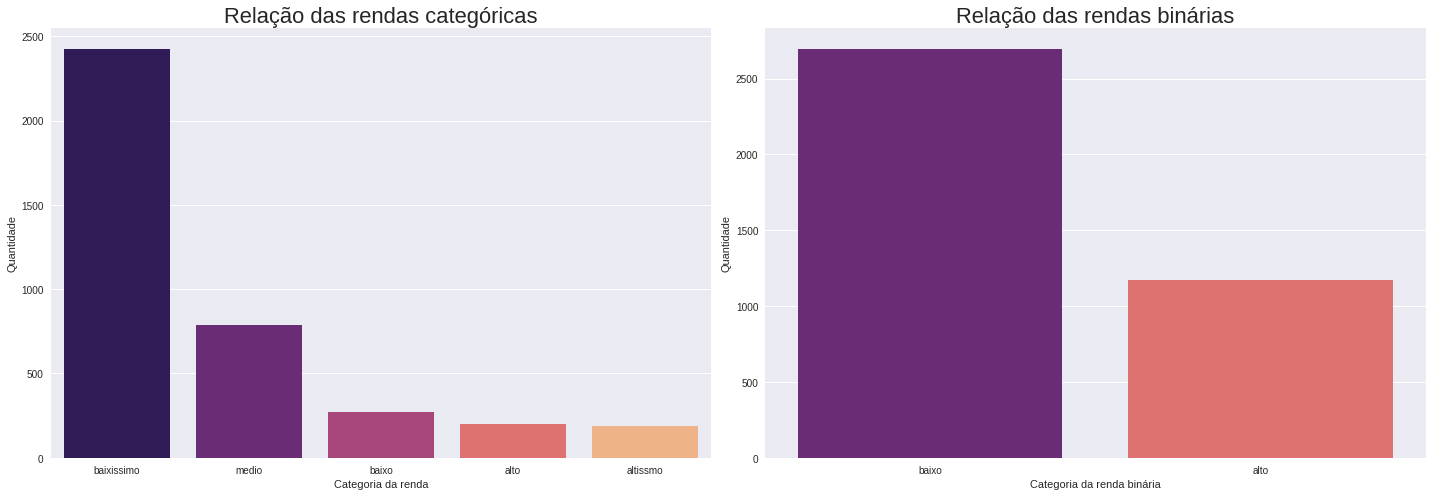

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.countplot(ax = axes[0],
              data = df_merged,
              x = 'rendacat',
              order = df_merged['rendacat'].value_counts().index,
              palette = 'magma').set_title('Relação das rendas categóricas', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Categoria da renda')
axes[0].set_ylabel('Quantidade')


sns.countplot(ax = axes[1],
              data = df_merged,
              x = 'rendabinaria',
              order = df_merged['rendabinaria'].value_counts().index,
              palette = 'magma').set_title('Relação das rendas binárias', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Categoria da renda binária')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

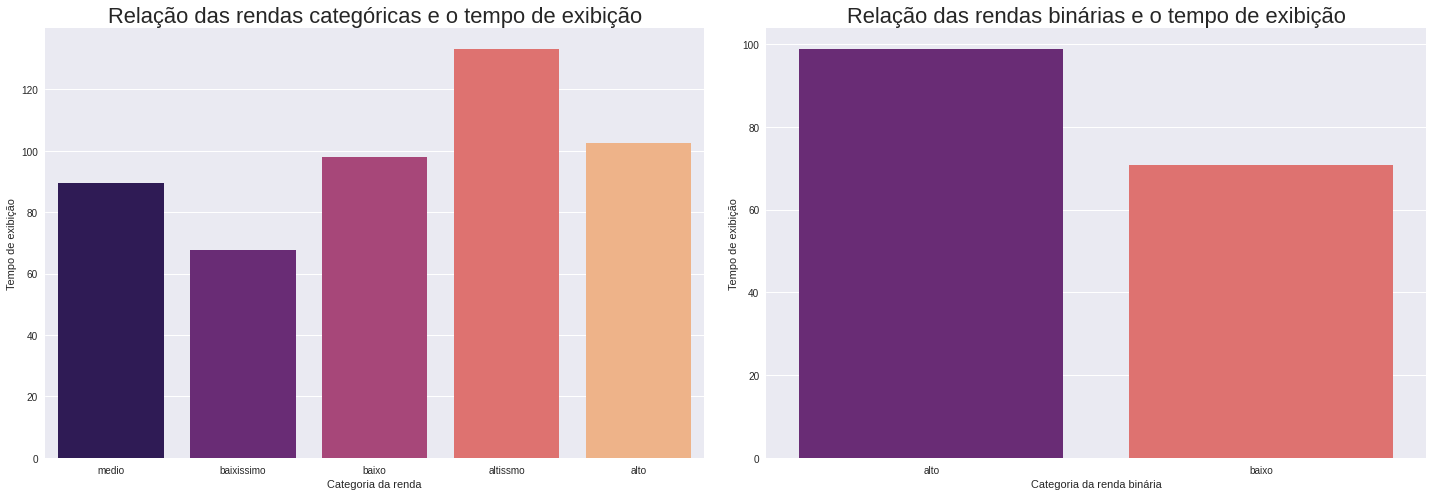

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_merged,
            x = 'rendacat',
            y = 'tempo_exibicao',
            ci = None,
            palette = 'magma').set_title('Relação das rendas categóricas e o tempo de exibição', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Categoria da renda')
axes[0].set_ylabel('Tempo de exibição')


sns.barplot(ax = axes[1],
            data = df_merged,
            x = 'rendabinaria',
            y = 'tempo_exibicao',
            ci = None,
            palette = 'magma').set_title('Relação das rendas binárias e o tempo de exibição', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Categoria da renda binária')
axes[1].set_ylabel('Tempo de exibição')

plt.tight_layout()
plt.show()

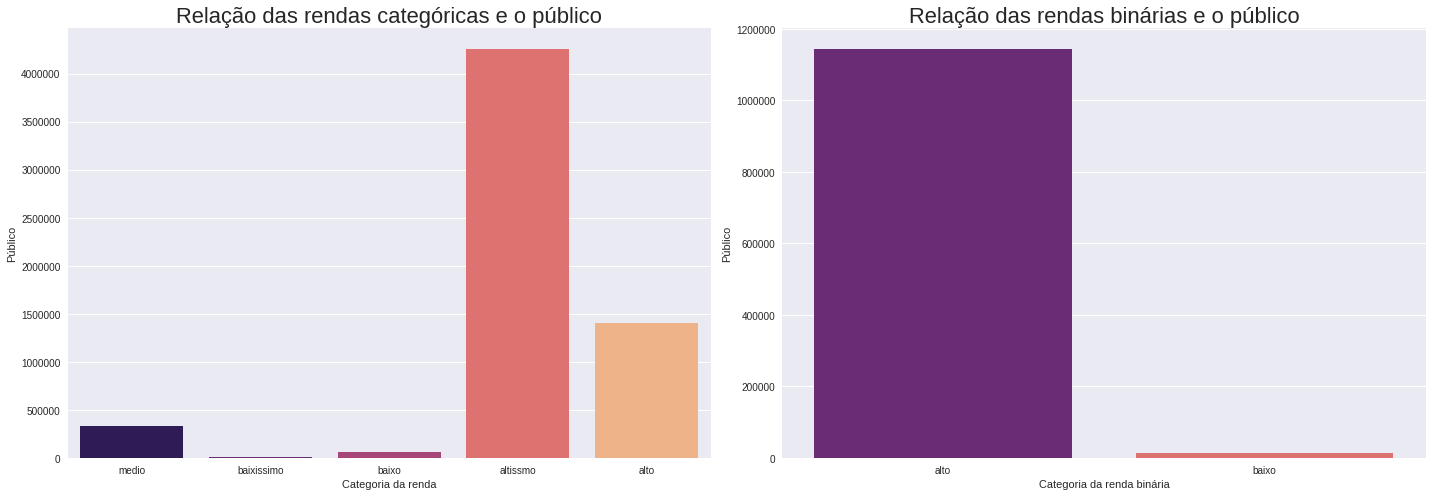

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.barplot(ax = axes[0],
            data = df_merged,
            x = 'rendacat',
            y = 'publico',
            ci = None,
            palette = 'magma').set_title('Relação das rendas categóricas e o público', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Categoria da renda')
axes[0].set_ylabel('Público')
axes[0].ticklabel_format(axis = "y", style = 'plain')

sns.barplot(ax = axes[1],
            data = df_merged,
            x = 'rendabinaria',
            y = 'publico',
            ci = None,
            palette = 'magma').set_title('Relação das rendas binárias e o público', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Categoria da renda binária')
axes[1].set_ylabel('Público')
axes[1].ticklabel_format(axis = "y", style = 'plain')

plt.tight_layout()
plt.show()

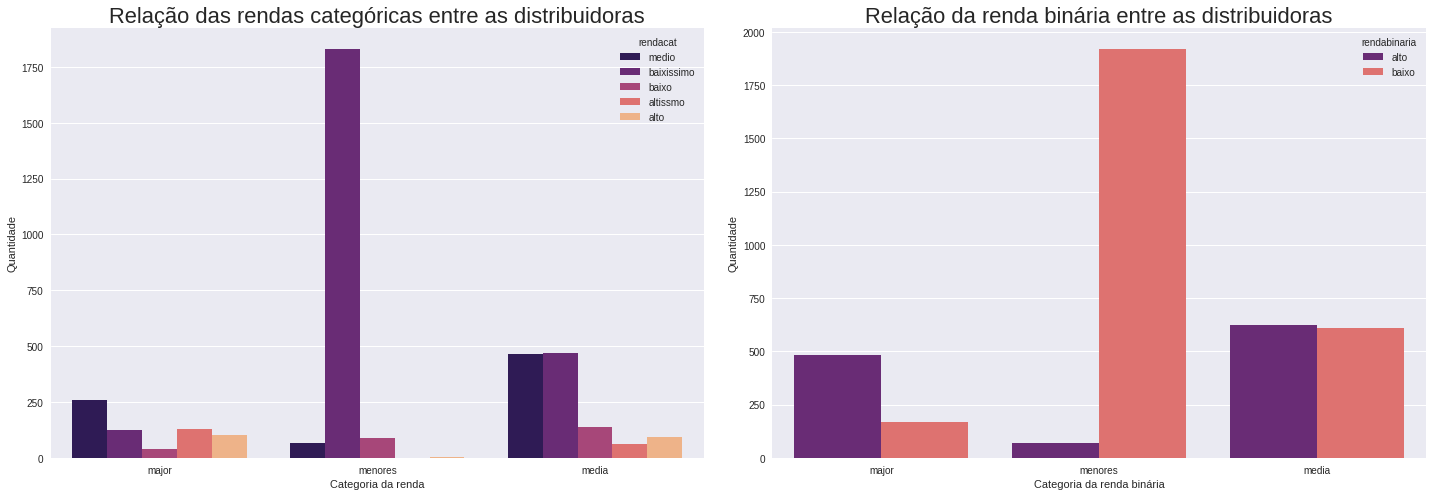

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.countplot(ax = axes[0],
              data = df_merged,
              x = 'distribuidoras',
              hue = 'rendacat',
              palette = 'magma').set_title('Relação das rendas categóricas entre as distribuidoras', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Categoria da renda')
axes[0].set_ylabel('Quantidade')


sns.countplot(ax = axes[1],
              data = df_merged,
              x = 'distribuidoras',
              hue = 'rendabinaria',
              palette = 'magma').set_title('Relação da renda binária entre as distribuidoras', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Categoria da renda binária')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

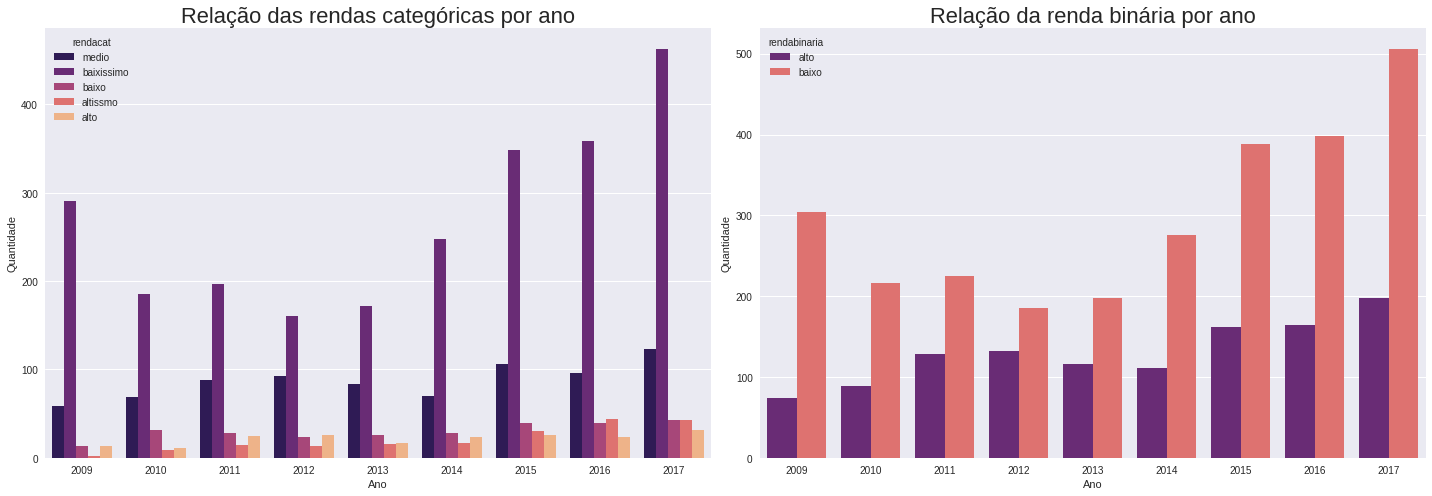

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.countplot(ax = axes[0],
              data = df_merged,
              x = 'ano_cinematografico',
              hue = 'rendacat',
              palette = 'magma').set_title('Relação das rendas categóricas por ano', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Quantidade')


sns.countplot(ax = axes[1],
              data = df_merged,
              x = 'ano_cinematografico',
              hue = 'rendabinaria',
              palette = 'magma').set_title('Relação da renda binária por ano', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

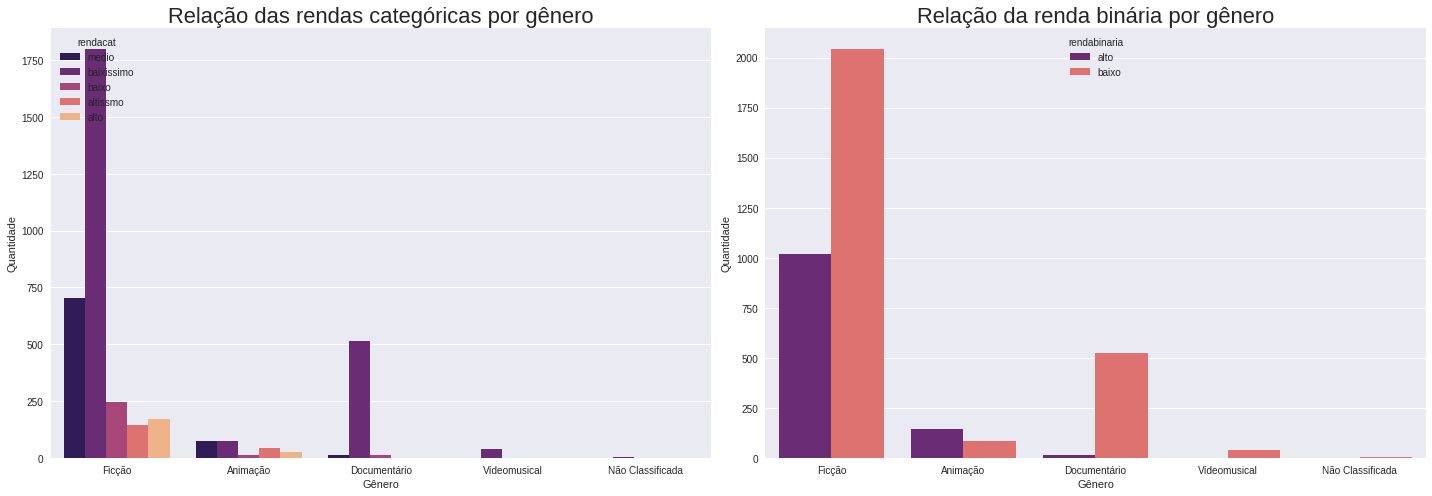

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.countplot(ax = axes[0],
              data = df_merged,
              x = 'genero',
              hue = 'rendacat',
              palette = 'magma').set_title('Relação das rendas categóricas por gênero', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Gênero')
axes[0].set_ylabel('Quantidade')


sns.countplot(ax = axes[1],
              data = df_merged,
              x = 'genero',
              hue = 'rendabinaria',
              palette = 'magma').set_title('Relação da renda binária por gênero', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Gênero')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

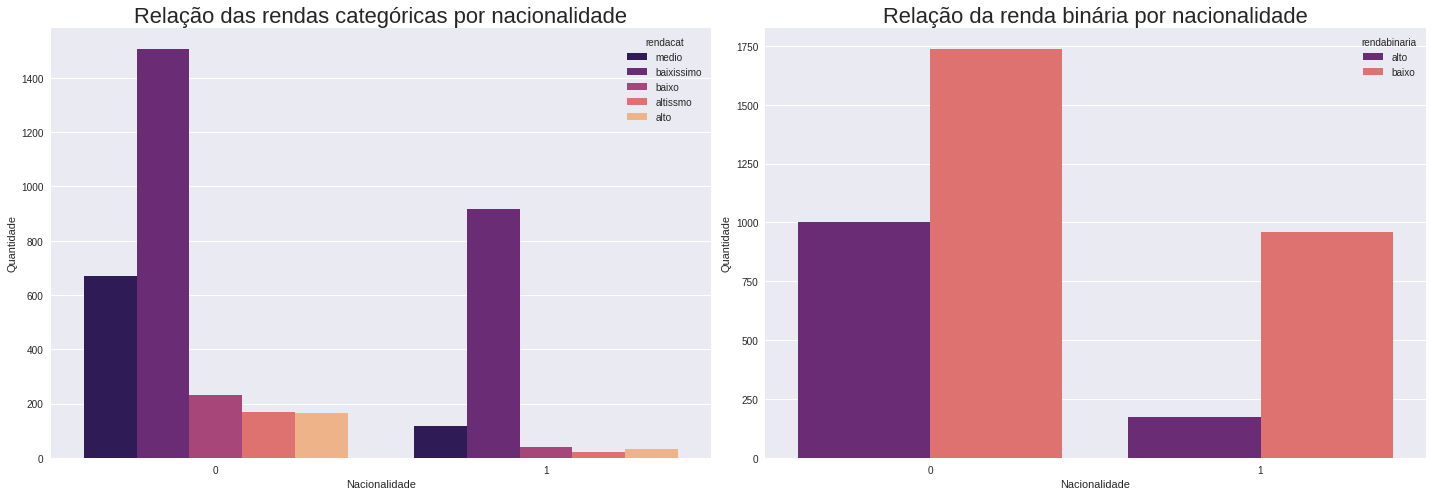

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7)) 

sns.countplot(ax = axes[0],
              data = df_merged,
              x = 'internacional_nacional',
              hue = 'rendacat',
              palette = 'magma').set_title('Relação das rendas categóricas por nacionalidade', fontsize = 22, fontweight = 200)
axes[0].set_xlabel('Nacionalidade')
axes[0].set_ylabel('Quantidade')


sns.countplot(ax = axes[1],
              data = df_merged,
              x = 'internacional_nacional',
              hue = 'rendabinaria',
              palette = 'magma').set_title('Relação da renda binária por nacionalidade', fontsize = 22, fontweight = 200)
axes[1].set_xlabel('Nacionalidade')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### **Relação de nacionalidade e tipo de distribuidora por gênero**

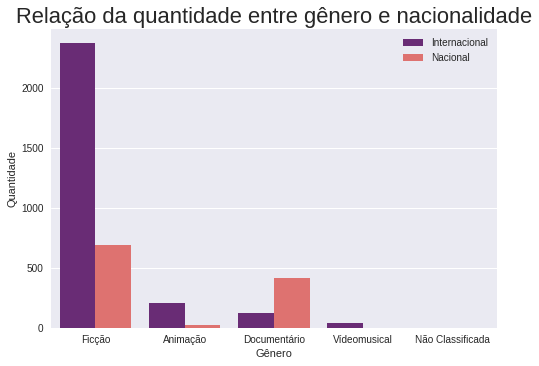

In [ ]:
sns.countplot(data = df_merged,
              x = 'genero',
              hue = 'internacional_nacional',
              palette = 'magma').set_title('Relação da quantidade entre gênero e nacionalidade', fontsize = 22, fontweight = 200)
plt.legend(np.arange(2), labels = ['Internacional','Nacional'], loc = 'upper right')
plt.xlabel('Gênero')
plt.ylabel('Quantidade');

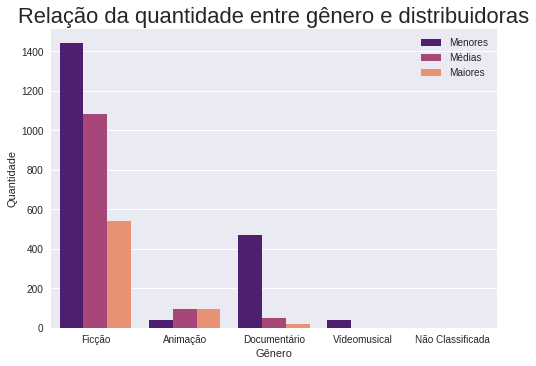

In [ ]:
sns.countplot(data = df_merged,
              x = 'genero',
              hue = 'distribuidoras',
              hue_order = ['menores', 'media', 'major'],
              palette = 'magma').set_title('Relação da quantidade entre gênero e distribuidoras', fontsize = 22, fontweight = 200)
plt.legend(np.arange(3), labels = ['Menores', 'Médias', 'Maiores'], loc = 'upper right')
plt.xlabel('Gênero')
plt.ylabel('Quantidade');

273 distribuidoras, para 3870 filmes. Destas, 61 atuam em produções nacionais.

Apenas 6 distribuidoras possuem rendimento médio individual acima de 10 milhões de reais para o período em análise. Tomadas em conjunto, contudo, apesar do alto rendimento ao longo do tempo com relação às demais distribuidoras, há algumas oscilações importantes. O mercado do cinema como um todo parece ter encontrado novas formas de se organizar a partir de 2010. Esse ano parece ter inaugurado o crescimento dos filmes de altíssimo rendimento - ou seja, filmes com rendimento acima de R$ 25 mi, sendo que houve um novo salto após 2014.  A tendência de alta observada para essa categoria, contudo, coincide com o declínio na ocorrência dos filmes de baixo e baixíssimo rendimento entre 2012 e 2013 (rendimento entre R$ 1 mi e R$ 500 mil e inferior a R$ 500 mil respectivamente) e com os filmes de alto rendimento (faturamento entre R$ 10 mi e R$ 25 mi) em 2013. A tendência dos rendimentos médios ano a ano das distribuidoras segue esse mesmo movimento. A consolidação da fórmula dos filmes de altíssimo rendimento parece ter passado por uma fase de experimentação entre 2010 e 2013 tomando o grupo das distribuidoras “major” para enfim consolidar acúmulo de altas a partir de 2014. Tanto os filmes de rendimento médio (faturamento de R$ 1 mi a R$ 10 mi) quanto as distribuidoras com rendimento individual médio nessa mesma faixa de valores  apresentaram flutuações maiores ao longo da série histórica tratada aqui. Não é possível observar tendências mais consolidadas de alta ou baixa. Há 13 distribuidoras nessa faixa de rendimento individual para o período.

### **Relações com o tempo de exibição**



In [ ]:
df_merged['tempo_exibicao'].describe()

count   3870.0000
mean      79.3121
std       59.7642
min        6.0000
25%       36.0000
50%       72.0000
75%      108.0000
max      978.0000
Name: tempo_exibicao, dtype: float64

In [ ]:
# Serão divididos os filmes a partir da mediana entre curtos e longos

df_merged['divisao_tempo_exibicao'] = df_merged['tempo_exibicao']

divisao = []
for i in df_merged['tempo_exibicao']:
    if i <= 72:
        divisao.append(0)
    else:
        divisao.append(1)
        
df_merged['divisao_tempo_exibicao'] = divisao

In [ ]:
df_merged['divisao_label'] = df_merged['divisao_tempo_exibicao'].replace({
    0: "Curto",
    1: "Longo"})

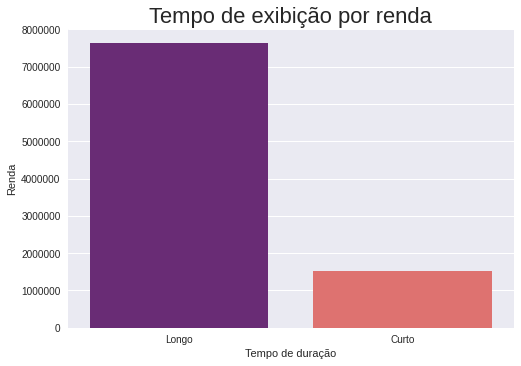

In [ ]:
sns.barplot(data = df_merged,
            x = 'divisao_label',
            y = 'renda',
            ci = None,
            palette = 'magma').set_title('Tempo de exibição por renda', fontsize = 22, fontweight = 200)
plt.ticklabel_format(axis = "y", style = 'plain')
plt.ylabel('Renda')
plt.xlabel('Tempo de duração');

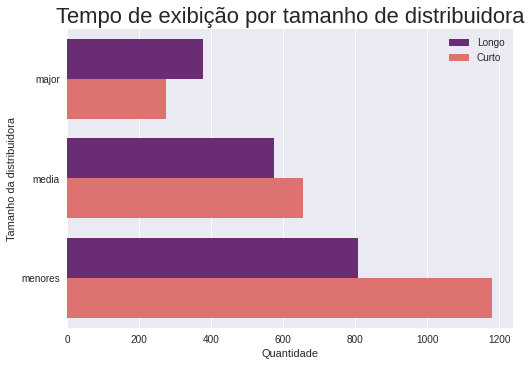

In [ ]:
sns.countplot(data = df_merged,
              y = 'distribuidoras',
              order = ['major', 'media', 'menores'],
              hue='divisao_label',
              palette = 'magma').set_title('Tempo de exibição por tamanho de distribuidora', fontsize = 22, fontweight = 200)
plt.legend()
plt.ylabel('Tamanho da distribuidora')
plt.xlabel('Quantidade');

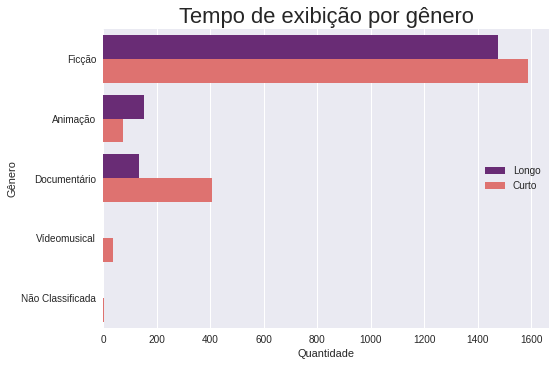

In [ ]:
sns.countplot(data = df_merged,
              y = 'genero',
              hue='divisao_label',
              palette = 'magma').set_title('Tempo de exibição por gênero', fontsize = 22, fontweight = 200)
plt.legend()
plt.ylabel('Gênero')
plt.xlabel('Quantidade');

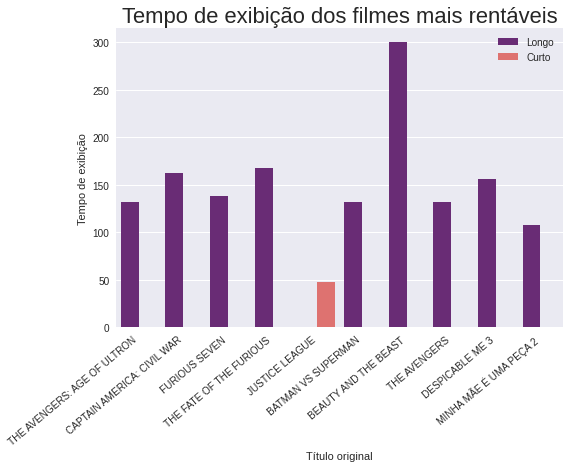

In [ ]:
df_merged = df_merged.sort_values(by = 'renda', ascending = False)
df2 = df_merged.head(10) # Escolhendo apenas 10

sns.barplot(data = df2,
            x = 'titulo_original',
            y = 'tempo_exibicao',
            hue = 'divisao_label',
            ci = None,
            palette = 'magma').set_title('Tempo de exibição dos filmes mais rentáveis', fontsize = 22, fontweight = 200)
plt.xticks(rotation = 40, ha = "right")
plt.legend()
plt.ylabel('Tempo de exibição')
plt.xlabel('Título original');

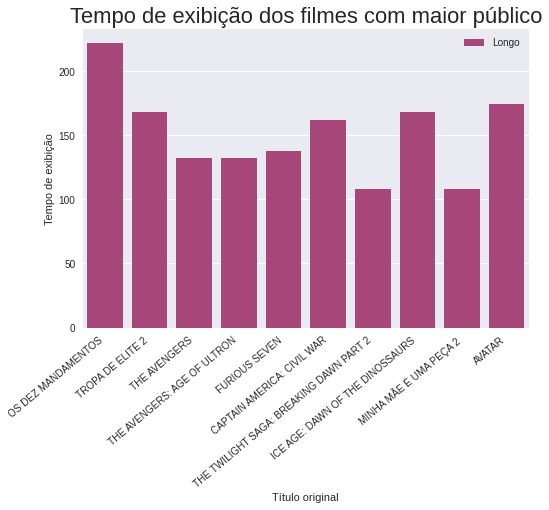

In [ ]:
df_merged = df_merged.sort_values(by = 'publico', ascending = False)
df2 = df_merged.head(10) # Escolhendo apenas 10

sns.barplot(data = df2,
            x = 'titulo_original',
            y = 'tempo_exibicao',
            hue = 'divisao_label',
            ci = None,
            palette = 'magma').set_title('Tempo de exibição dos filmes com maior público', fontsize = 22, fontweight = 200)
plt.xticks(rotation = 40, ha = "right")
plt.legend()
plt.ylabel('Tempo de exibição')
plt.xlabel('Título original');

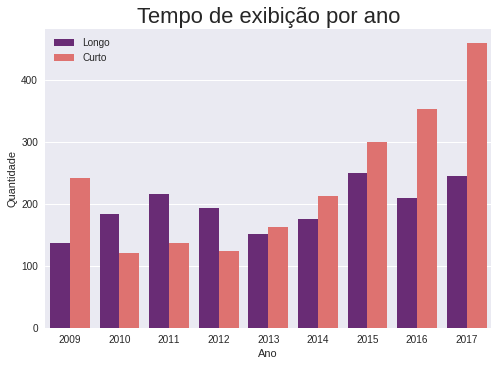

In [ ]:
sns.countplot(data = df_merged,
              x = 'ano_cinematografico',
              hue = 'divisao_label',
              palette = 'magma').set_title('Tempo de exibição por ano', fontsize = 22, fontweight = 200)
plt.legend()
plt.ylabel('Quantidade')
plt.xlabel('Ano');

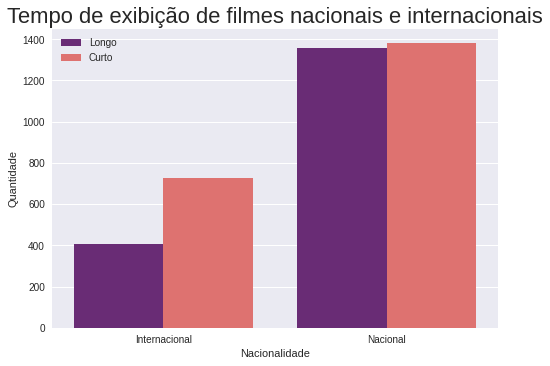

In [ ]:
sns.countplot(data = df_merged,
              x = 'internacional_nacional',
              hue = 'divisao_label',
              palette = 'magma').set_title('Tempo de exibição de filmes nacionais e internacionais', fontsize = 22, fontweight = 200)
plt.legend()
plt.xticks([0, 1], ['Internacional', 'Nacional'])
plt.xlabel('Nacionalidade')
plt.ylabel('Quantidade');

## Modelagem

### **Vale a pena ou não comprar um filme?**

Para a realização deste modelo, é necessário saber a renda que a bilheteria deve ter com um determinado filme para ser rentável ao cinema.

De acordo com [este documento do SEBRAE](https://bibliotecas.sebrae.com.br/chronus/ARQUIVOS_CHRONUS/IDEIAS_DE_NEGOCIO/PDFS/72.pdf), estima-se que o custo mensal para um cinema de pequeno porte seja da ordem de 85% do faturamento total (50% do arrecadado na bilheteria são pagos para as distribuidoras) e que o preço para manter um cinema de uma sala de 100 lugares que apresenta uma fatura em média de 600 mil reais por ano é de 510 mil reais.

Como o cinema em questão possui 2 salas com capacidade para 150 pessoas e 1 sala com capacidade para 84 pessoas, portanto, supondo que as salas lotem:

- 2 salas de 150 lugares: 1.800.000 reais por ano
- 1 sala de 84 lugares: 504.000 reais por ano

O somatório é de 2.304.000 reais por ano, o que é em torno de 192.000 reais por mês e isto menos o custo de 85% mensal fica 28.800 por mês.

Será criada então uma nova variável descontando os 85% da renda a fim de saber se o filme venderá acima ou abaixo de 28.800.

In [ ]:
df_merged2 = reduce(lambda  left,right: pd.merge(left,right,on=['titulo_original'],
                                            how='outer'), data_frames)

Como a distribuidora importa, será feita uma ordenação com base na renda gerada

In [ ]:
df_merged2 = df_merged2.sort_values(by = 'renda', ascending = False)

Como a renda exibida para os filmes é somando o tempo que ficaram em exbição, será feita uma estimativa para saber quanto os filmes renderam com 1 mês no cinema

In [ ]:
df_merged2['tempo_exibicao'] = df_merged2['tempo_exibicao'].dt.days
df_merged2['renda_mes'] = (30 * df_merged2['renda'])/df_merged2['tempo_exibicao']

In [ ]:
# Criando a variável para o lucro do mês

df_merged2['lucro'] = df_merged2['renda_mes']*0.15

In [ ]:
# Criando a variável se vale ou não a pena comprar

renda_alta_baixa = []

for lucro in df_merged2.lucro:
  if lucro < 28800:
    renda_alta_baixa.append(0) # Não vale a pena comprar
  else:
    renda_alta_baixa.append(1) # Vale a pena comprar

df_merged2['renda_alta_baixa'] = renda_alta_baixa

In [ ]:
colunas = ['genero', 'razao_social_distribuidora', 'internacional_nacional' , 'renda_alta_baixa']
features = ['genero', 'razao_social_distribuidora', 'internacional_nacional']
target = ['renda_alta_baixa']

In [ ]:
data = df_merged2.copy()
data = data[colunas]

In [ ]:
le = LabelEncoder()

for x in data.columns:
  if data[x].dtype == 'object':
    data[x] = le.fit_transform(data[x])

data.head()

,genero,razao_social_distribuidora,internacional_nacional,renda_alta_baixa
3,2,242,0,1
5,2,242,0,1
4,2,67,0,1
14,2,253,0,1
16,2,266,0,1


In [ ]:
X = data[features]
y = data[target]

In [ ]:
# Observando o target

y.value_counts()

renda_alta_baixa
0                   2403
1                   1467
dtype: int64

Será utilizado do oversampling nos dados de treino a fim de balancear os dados de filmes que valem a pena comprar

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
df_over = pd.concat([X_train, y_train], axis = 1)

nao_comprar = df_over[df_over.renda_alta_baixa == 0]
comprar = df_over[df_over.renda_alta_baixa == 1]

# Upsampled da minoria
comprar_upsampled = resample(comprar, replace = True, n_samples = len(nao_comprar), random_state = 0)

# Combinando a maioria com a upsampled minoria
upsampled = pd.concat([nao_comprar, comprar_upsampled])

upsampled.renda_alta_baixa.value_counts()

0    1934
1    1934
Name: renda_alta_baixa, dtype: int64

In [ ]:
# Separando as features do target

X_train = upsampled[features]
y_train = upsampled[target]

Foram escolhidos três modelos a fim de comparar suas performances, sendo eles:

- Decision Tree
- XGBoost
- Random Forest Classifier

In [ ]:
# Instanciando os modelos

dtc = DecisionTreeClassifier(max_depth = 12, random_state = 42)
xgb = XGBClassifier(max_depth = 5, objective = 'binary:logistic', random_state = 42)
rfc = RandomForestClassifier(max_depth = 12, random_state = 42)


**Treino com Decision Tree**

In [ ]:
# Validação cruzada

scores_decision_tree = cross_val_score(dtc, X_train, y_train, cv = 5, scoring = 'f1')
scores_decision_tree.mean().round(4)

0.8514

In [ ]:
dtc.fit(X_train, y_train)

train_predictions = dtc.predict(X_train)
test_predictions = dtc.predict(X_test)

decision_tree = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
                 'Decision Tree': [accuracy_score(y_test, test_predictions), recall_score(y_test, test_predictions), f1_score(y_test, test_predictions), roc_auc_score(y_test, test_predictions)]}
a = pd.DataFrame(data = decision_tree)

# Checando os resultados de treino e teste
print(f'O F1 de treino é {f1_score(train_predictions, y_train).round(4)}')
print(f'O F1 de teste é {f1_score(test_predictions, y_test).round(4)}')

O F1 de treino é 0.866
O F1 de teste é 0.8093


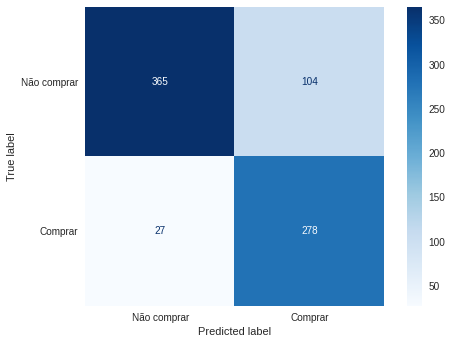

In [ ]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não comprar', 'Comprar'])
disp.plot(cmap = 'Blues')
plt.grid(False)

**Treino com XGBoost**

In [ ]:
# Validação cruzada

scores_decision_tree = cross_val_score(xgb, X_train, y_train, cv = 5, scoring = 'f1')
scores_decision_tree.mean().round(4)

0.8513

In [ ]:
xgb.fit(X_train, y_train)

train_predictions = xgb.predict(X_train)
test_predictions = xgb.predict(X_test)

xgboost = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
           'XGBoost': [accuracy_score(y_test, test_predictions), recall_score(y_test, test_predictions), f1_score(y_test, test_predictions), roc_auc_score(y_test, test_predictions)]}
b = pd.DataFrame(data = xgboost)

# Checando os resultados de treino e teste
print(f'O F1 de treino é {f1_score(train_predictions, y_train).round(4)}')
print(f'O F1 de teste é {f1_score(test_predictions, y_test).round(4)}')

O F1 de treino é 0.8601
O F1 de teste é 0.811


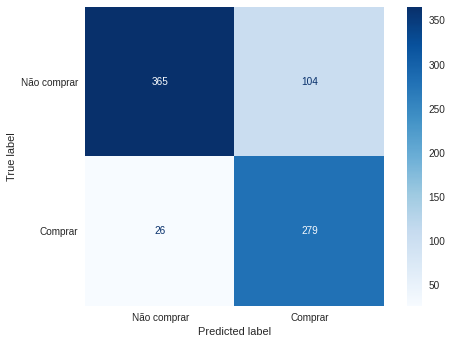

In [ ]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não comprar', 'Comprar'])
disp.plot(cmap = 'Blues')
plt.grid(False)

**Treino com Random Forest Classifier**

In [ ]:
# Validação cruzada

scores_decision_tree = cross_val_score(rfc, X_train, y_train, cv = 5, scoring = 'f1')
scores_decision_tree.mean().round(4)

0.8517

In [ ]:
rfc.fit(X_train, y_train)

train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)

random_forest = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
                 'Random Forest': [accuracy_score(y_test, test_predictions), recall_score(y_test, test_predictions), f1_score(y_test, test_predictions), roc_auc_score(y_test, test_predictions)]}
c = pd.DataFrame(data = random_forest)

# Checando os resultados de treino e teste
print(f'O F1 de treino é {f1_score(train_predictions, y_train).round(4)}')
print(f'O F1 de teste é {f1_score(test_predictions, y_test).round(4)}')

O F1 de treino é 0.8664
O F1 de teste é 0.8064


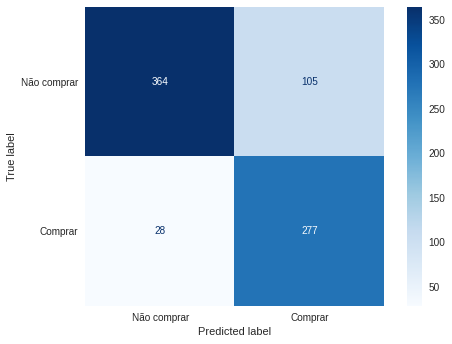

In [ ]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não comprar', 'Comprar'])
disp.plot(cmap = 'Blues')
plt.grid(False)

In [ ]:
# Exibindo os resultados dos testes

metricas = [a, b, c]
resultados = reduce(lambda  left, right: pd.merge(left, right, on = ['Teste'], how = 'outer'), metricas)
resultados

,Teste,Decision Tree,XGBoost,Random Forest
0,Acurácia,0.8307,0.8320,0.8282
1,Recall,0.9115,0.9148,0.9082
2,F1,0.8093,0.8110,0.8064
3,ROC-AUC Score,0.8449,0.8465,0.8422


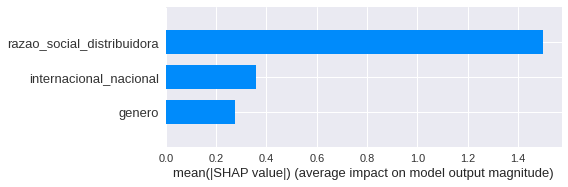

In [ ]:
# Observando a importância das features no modelo

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

É possível notar que o modelo com as melhores métricas foi o do XGBoost. Porém, como se trata de um cinema pequeno, talvez seja uma boa alternativa recorrer à Decision Tree, pois, além de um modelo simples e fácil de se explicar, ele exige menos poder computacional, ou seja, é mais barato e também suas métricas foram muito próximas ao modelo XGBoost.

Para o cinema de pequeno porte em questão, que não possui um faturamento altíssimo como cinemas com várias franquias, não seria interessante um modelo mais caro, podendo estourar o orçamento.

### **Outro modelo para saber se comprar um filme ou não**

Este modelo será feito aplicando a regressão logística como uma alternativa de não levar em conta os custos do cinema

In [ ]:
df2 = df_merged.copy(deep = True)

In [ ]:
df2['rendabinaria'] = df2['rendabinaria'].map({'alto': 1, 'baixo': 0})
df2 = pd.get_dummies(df2, columns = ['internacional_nacional', 'genero', 'distribuidoras'])

In [ ]:
df2.drop(columns=['preco_medio_ingresso', 'salas', 'ano_cinematografico', 'razao_social_distribuidora', 'titulo_original', 'genero_Documentário', 'genero_Não Classificada', 'genero_Vídeomusical', 'rendacat', 'renda'], inplace=True)
df2.head(2)

,publico,tempo_exibicao,rendabinaria,divisao_tempo_exibicao,divisao_label,internacional_nacional_0,internacional_nacional_1,genero_Animação,genero_Ficção,distribuidoras_major,distribuidoras_media,distribuidoras_menores
0,11305479,222,1,1,Longo,0,1,0,1,0,1,0
1,11146723,168,1,1,Longo,0,1,0,1,1,0,0


In [ ]:
# Definindo as variáveis de treino e teste

X_train = df2[['internacional_nacional_1', 'genero_Animação', 'genero_Ficção', 'distribuidoras_major', 'distribuidoras_media']]
y_train = df2['rendabinaria']

X_test = df2[['internacional_nacional_1', 'genero_Animação', 'genero_Ficção', 'distribuidoras_major', 'distribuidoras_media']]
y_test = df2['rendabinaria']

In [ ]:
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.458503
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           rendabinaria   No. Observations:                 3870
Model:                          Logit   Df Residuals:                     3865
Method:                           MLE   Df Model:                            4
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                  0.2529
Time:                        13:42:50   Log-Likelihood:                -1774.4
converged:                       True   LL-Null:                       -2375.0
Covariance Type:            nonrobust   LLR p-value:                9.204e-259
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
internacional_nacional_1    -1.6303      0.094    -17.280      0.000      -1.815

In [ ]:
# Realizando as predições

yhat = log_reg.predict(X_test)
prediction = list(map(round, yhat))

In [ ]:
reg_log = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
           'Regressão Logística': [accuracy_score(y_test, prediction), recall_score(y_test, prediction), f1_score(y_test, prediction), roc_auc_score(y_test, prediction)]}
pd.DataFrame(reg_log)

,Teste,Regressão Logística
0,Acurácia,0.7798
1,Recall,0.8049
2,F1,0.6893
3,ROC-AUC Score,0.7869


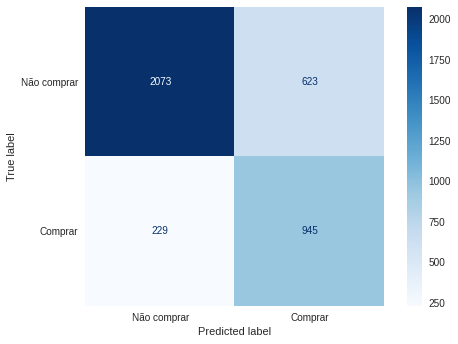

In [ ]:
cnf_matrix = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Não comprar', 'Comprar'])
disp.plot(cmap = 'Blues')
plt.grid(False)

Como é possível observar, levar em consideração os custos do cinema possui um grande impacto no resultado do modelo

### **Quanto tempo deixar um filme em cartaz?**

In [ ]:
df2 = df_merged.copy(deep = True)

In [ ]:
encoder = LabelEncoder()

df2['genero'] = encoder.fit_transform(df2['genero'])
df2['razao_social_distribuidora'] = encoder.fit_transform(df2['razao_social_distribuidora'])
df2['internacional_nacional'] = encoder.fit_transform(df2['internacional_nacional'])

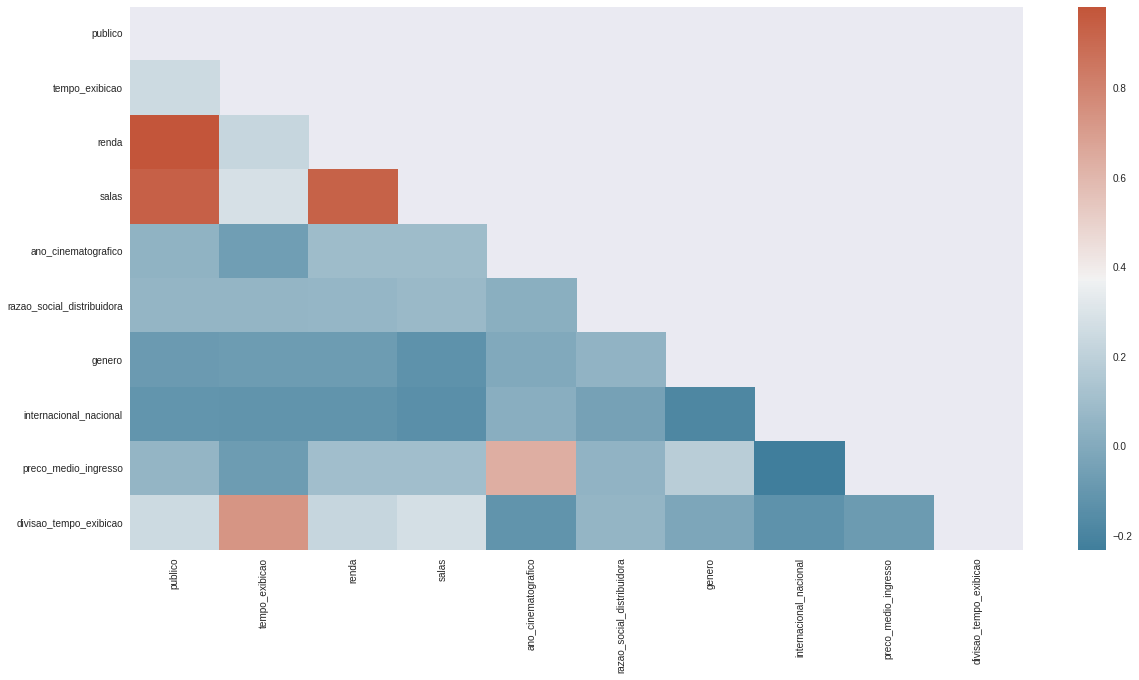

In [ ]:
corr_matrix = df2.corr()
f, ax = plt.subplots(figsize=(20, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, annot=False, mask = mask, cmap=cmap);

In [ ]:
df2.drop(columns = ['renda', 'publico', 'tempo_exibicao'], axis = 1, inplace = True)

In [ ]:
df2.isna().sum()

titulo_original               0
salas                         0
ano_cinematografico           0
razao_social_distribuidora    0
genero                        0
internacional_nacional        0
preco_medio_ingresso          1
distribuidoras                0
rendacat                      0
rendabinaria                  0
divisao_tempo_exibicao        0
divisao_label                 0
dtype: int64

In [ ]:
df2.dropna(axis = 0, subset = ['preco_medio_ingresso'], inplace = True)

In [ ]:
X = df2[['genero', 'salas', 'preco_medio_ingresso', 'internacional_nacional','razao_social_distribuidora', 'ano_cinematografico']]
y = df2['divisao_tempo_exibicao']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Foram escolhidos os seguintes modelos a fim de comparar suas perfomances:
- Decision Tree
- XGBoost
- Random Forest Classifier

In [ ]:
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 42, min_samples_split = 20, max_depth = 10)
xgb = XGBClassifier(max_depth = 6, max_leaf_nodes = 2, min_samples_leaf = 2, min_samples_split = 2, random_state = 42)
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42, min_samples_split = 20, max_depth = 10)

**Treino com Decision Tree**

In [ ]:
# Validação cruzada

scores_decision_tree = cross_val_score(dtc, X_train, y_train, cv = 5, scoring = 'f1')
scores_decision_tree.mean().round(4)

0.7063

In [ ]:
dtc.fit(X_train, y_train)

train_predictions = dtc.predict(X_train)
test_predictions = dtc.predict(X_test)

decision_tree = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
                 'Decision Tree': [accuracy_score(y_test, test_predictions), recall_score(y_test, test_predictions), f1_score(y_test, test_predictions), roc_auc_score(y_test, test_predictions)]}
a = pd.DataFrame(data = decision_tree)

# Checando os resultados de treino e teste
print(f'O F1 de treino é {f1_score(train_predictions, y_train).round(4)}')
print(f'O F1 de teste é {f1_score(test_predictions, y_test).round(4)}')

O F1 de treino é 0.7782
O F1 de teste é 0.7266


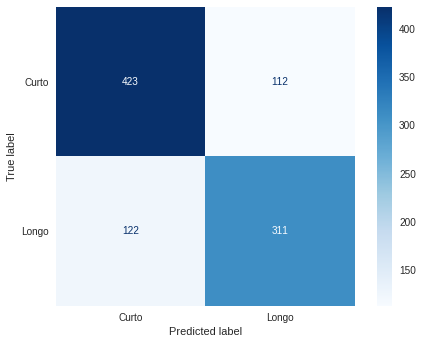

In [ ]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Curto', 'Longo'])
disp.plot(cmap = 'Blues')
plt.grid(False)

**Treino com XGBoost**

In [ ]:
# Validação cruzada

scores_decision_tree = cross_val_score(xgb, X_train, y_train, cv = 5, scoring = 'f1')
scores_decision_tree.mean().round(4)

0.7533

In [ ]:
xgb.fit(X_train, y_train)

train_predictions = xgb.predict(X_train)
test_predictions = xgb.predict(X_test)

xgboost = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
           'XGBoost': [accuracy_score(y_test, test_predictions), recall_score(y_test, test_predictions), f1_score(y_test, test_predictions), roc_auc_score(y_test, test_predictions)]}
b = pd.DataFrame(data = xgboost)

# Checando os resultados de treino e teste
print(f'O F1 de treino é {f1_score(train_predictions, y_train).round(4)}')
print(f'O F1 de teste é {f1_score(test_predictions, y_test).round(4)}')

O F1 de treino é 0.8761
O F1 de teste é 0.7881


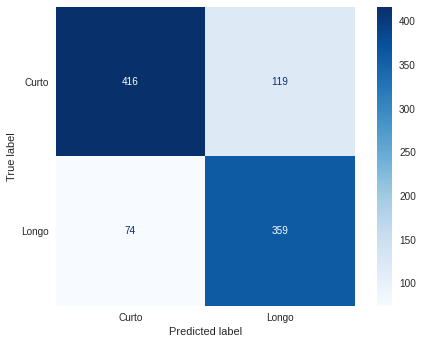

In [ ]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Curto', 'Longo'])
disp.plot(cmap = 'Blues')
plt.grid(False)

**Treino com Random Forest**

In [ ]:
# Validação cruzada

scores_decision_tree = cross_val_score(rfc, X_train, y_train, cv = 5, scoring = 'f1')
scores_decision_tree.mean().round(4)

0.748

In [ ]:
rfc.fit(X_train, y_train)

train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)

random_forest = {'Teste': ['Acurácia', 'Recall', 'F1', 'ROC-AUC Score'],
                 'Random Forest': [accuracy_score(y_test, test_predictions), recall_score(y_test, test_predictions), f1_score(y_test, test_predictions), roc_auc_score(y_test, test_predictions)]}
c = pd.DataFrame(data = random_forest)

# Checando os resultados de treino e teste
print(f'O F1 de treino é {f1_score(train_predictions, y_train).round(4)}')
print(f'O F1 de teste é {f1_score(test_predictions, y_test).round(4)}')

O F1 de treino é 0.822
O F1 de teste é 0.7718


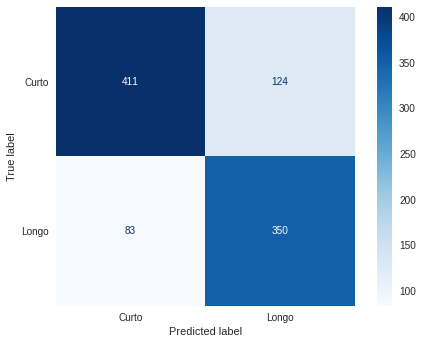

In [ ]:
cnf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Curto', 'Longo'])
disp.plot(cmap = 'Blues')
plt.grid(False)

In [ ]:
# Exibindo os resultados dos testes

metricas = [a, b, c]
resultados = reduce(lambda  left, right: pd.merge(left, right, on = ['Teste'], how = 'outer'), metricas)
resultados

,Teste,Decision Tree,XGBoost,Random Forest
0,Acurácia,0.7583,0.8006,0.7862
1,Recall,0.7182,0.8291,0.8083
2,F1,0.7266,0.7881,0.7718
3,ROC-AUC Score,0.7544,0.8033,0.7883


Podemos observar que as métricas do XGBoost foram melhores como também sua matriz de confusão foi a melhor dos 3 modelos.

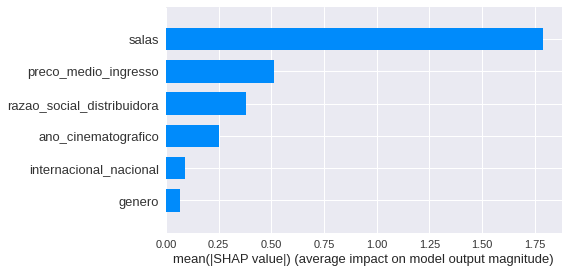

In [ ]:
# Observando a importância das features no modelo

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

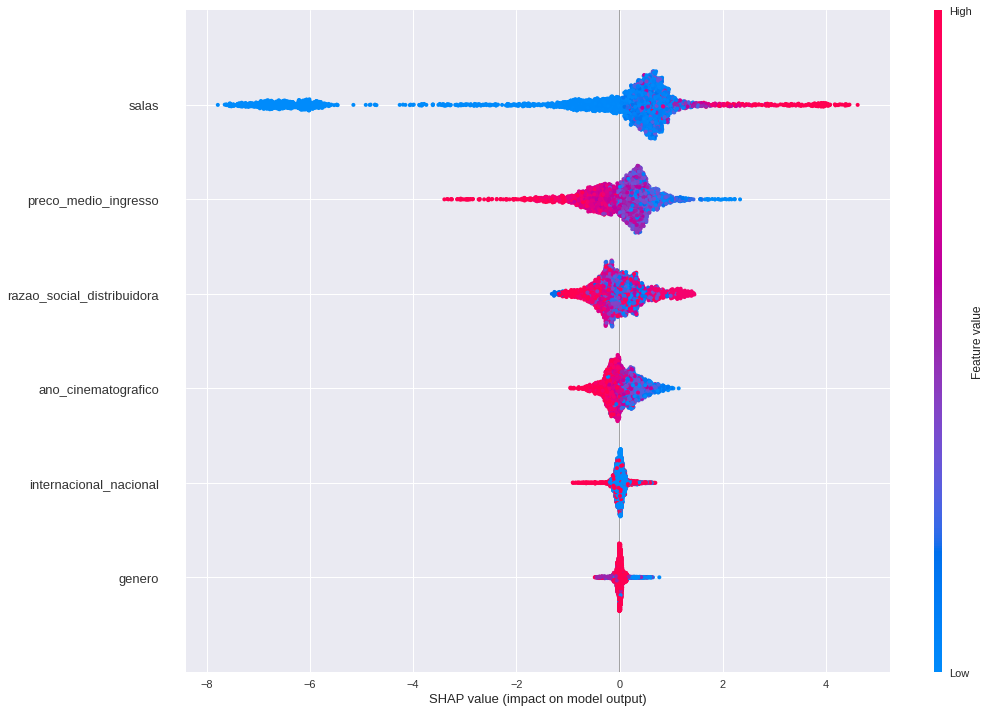

In [ ]:
explainer = shap.TreeExplainer(xgb) 
shap_values = explainer.shap_values(X_train) 
shap.summary_plot(shap_values, X_train, plot_size = (15, 10)) 

Valores baixos para a variável salas têm um impacto negativo sobre a predição e valores altos para preço do ingresso têm impacto negativo sobre a predição